## Imports

In [1]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

In [5]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.5 MB/s eta 0:00:00


In [2]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

In [3]:
from google.colab import userdata
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')

In [4]:
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Indexing

### Load PDFs and Convert to Documents

Load multiple PDFs and convert their text into `Document` objects for LangChain

In [6]:
import pdfplumber
from langchain.docstore.document import Document

In [7]:
pdf_dir = "/content/drive/MyDrive/Medical Treatment Guidelines"

# Function to load PDFs and create documents
def load_pdfs_to_documents(pdf_dir):
    docs = []
    for file in os.listdir(pdf_dir):
        if file.endswith(".pdf"):
            pdf_path = os.path.join(pdf_dir, file)
            with pdfplumber.open(pdf_path) as pdf:
                full_text = ""
                for page in pdf.pages:
                    full_text += page.extract_text()
                # Create a Document object
                docs.append(Document(page_content=full_text, metadata={"source": file}))
    return docs

# Load all PDFs into Document objects
documents = load_pdfs_to_documents(pdf_dir)

In [8]:
len(documents)

10

In [10]:
documents[0]

Document(metadata={'source': 'First Aid.pdf'}, page_content='First Aid\nFirst aid is the first and immediate assistance given to any person with a medical\n[1]\nemergency, with care provided to preserve life, prevent the condition from\nworsening, or to promote recovery until medical services arrive. First aid is generally\nperformed by someone with basic medical or first response training.\nLearn the first aid method of DRSABCD\nFirst aid is as easy as ABC – airway, breathing and CPR (cardiopulmonary\nresuscitation). In any situation, apply the DRSABCD Action Plan.\nDRSABCD stands for:\n● Danger – always check the danger to you, any bystanders and then the\ninjured or ill person. Make sure you do not put yourself in danger when going\nto the assistance of another person.\n● Response – is the person conscious? Do they respond when you talk to them,\ntouch their hands or squeeze their shoulder?\n● Send for help – call triple zero (000). Don’t forget to answer the questions\nasked by the

### Split Documents into Chunks

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [16]:
# Initialize the splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Split the documents into chunks
split_docs = text_splitter.split_documents(documents)

In [17]:
len(split_docs)

144

In [18]:
split_docs[0]

Document(metadata={'source': 'First Aid.pdf'}, page_content='First Aid\nFirst aid is the first and immediate assistance given to any person with a medical\n[1]\nemergency, with care provided to preserve life, prevent the condition from\nworsening, or to promote recovery until medical services arrive. First aid is generally\nperformed by someone with basic medical or first response training.\nLearn the first aid method of DRSABCD\nFirst aid is as easy as ABC – airway, breathing and CPR (cardiopulmonary\nresuscitation). In any situation, apply the DRSABCD Action Plan.\nDRSABCD stands for:\n● Danger – always check the danger to you, any bystanders and then the\ninjured or ill person. Make sure you do not put yourself in danger when going\nto the assistance of another person.\n● Response – is the person conscious? Do they respond when you talk to them,\ntouch their hands or squeeze their shoulder?\n● Send for help – call triple zero (000). Don’t forget to answer the questions\nasked by the

In [19]:
split_docs[1]

Document(metadata={'source': 'First Aid.pdf'}, page_content='asked by the operator.\n● Airway – Is the person’s airway clear? Is the person breathing?\n● If the person is responding, they are conscious and their airway is clear,\nassess how you can help them with any injury.\n● If the person is not responding and they are unconscious, you need to check\ntheir airway by opening their mouth and having a look inside. If their mouth is\nclear, tilt their head gently back (by lifting their chin) and check for breathing. If\nthe mouth is not clear, place the person on their side, open their mouth and\nclear the contents, then tilt the head back and check for breathing.\n● Breathing – check for breathing by looking for chest movements (up and\ndown). Listen by putting your ear near to their mouth and nose. Feel for\nbreathing by putting your hand on the lower part of their chest. If the person is\nunconscious but breathing, turn them onto their side, carefully ensuring that\nyou keep their he

In [20]:
split_docs[140]

Document(metadata={'source': 'Lung Diseases.pdf'}, page_content='inhaling something that injures your lungs. Examples include black\nlung disease from coal dust and asbestosis from asbestos dust.\nRelated:\n5 Common Lung Cancer Tests\nLung Diseases Affecting the Interstitium\nThe interstitium is the thin, delicate lining between your alveoli. Tiny\nblood vessels run through the interstitium and let gas transfer between\nthe alveoli and your blood. Various lung diseases affect the interstitium:\n● Interstitial lung disease (ILD). This is a group of lung conditions\nthat includes sarcoidosis, idiopathic pulmonary fibrosis, and\nautoimmune disease.\n● Pneumonia and pulmonary edema can also affect your interstitium.\nLung Diseases Affecting Blood Vessels\nThe right side of your heart gets low-oxygen blood from your veins. It\npumps blood into your lungs through the pulmonary arteries. These\nblood vessels can have diseases, as well.\n● Pulmonary embolism(PE). A blood clot (usually in a dee

### Embed the Chunks and Add to VectorStore

Chroma is a community-maintained vector store that's highly efficient. (automatically embed when adding to vector store)

In [22]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

In [23]:
vectorstore = Chroma.from_documents(documents=split_docs,
                                    embedding=OpenAIEmbeddings())

#### Test to Query the Vector Store

In [25]:
# Perform a similarity search
query = "What does the 'D' in DRSABCD stand for in first aid?"
results = vectorstore.similarity_search(query, k=3)

# Display results
for i, doc in enumerate(results):
    print(f"Result {i + 1}: {doc.page_content}\n")

Result 1: First Aid
First aid is the first and immediate assistance given to any person with a medical
[1]
emergency, with care provided to preserve life, prevent the condition from
worsening, or to promote recovery until medical services arrive. First aid is generally
performed by someone with basic medical or first response training.
Learn the first aid method of DRSABCD
First aid is as easy as ABC – airway, breathing and CPR (cardiopulmonary
resuscitation). In any situation, apply the DRSABCD Action Plan.
DRSABCD stands for:
● Danger – always check the danger to you, any bystanders and then the
injured or ill person. Make sure you do not put yourself in danger when going
to the assistance of another person.
● Response – is the person conscious? Do they respond when you talk to them,
touch their hands or squeeze their shoulder?
● Send for help – call triple zero (000). Don’t forget to answer the questions
asked by the operator.
● Airway – Is the person’s airway clear? Is the person b

## Retrieval

### VectorStore as Retriever

In [38]:
retriever = vectorstore.as_retriever()

In [39]:
# Lets trace in LangSmith
docs = retriever.get_relevant_documents("What does the 'D' in DRSABCD stand for in first aid?")

In [40]:
len(docs)

4

In [41]:
docs

[Document(metadata={'source': 'First Aid.pdf'}, page_content='First Aid\nFirst aid is the first and immediate assistance given to any person with a medical\n[1]\nemergency, with care provided to preserve life, prevent the condition from\nworsening, or to promote recovery until medical services arrive. First aid is generally\nperformed by someone with basic medical or first response training.\nLearn the first aid method of DRSABCD\nFirst aid is as easy as ABC – airway, breathing and CPR (cardiopulmonary\nresuscitation). In any situation, apply the DRSABCD Action Plan.\nDRSABCD stands for:\n● Danger – always check the danger to you, any bystanders and then the\ninjured or ill person. Make sure you do not put yourself in danger when going\nto the assistance of another person.\n● Response – is the person conscious? Do they respond when you talk to them,\ntouch their hands or squeeze their shoulder?\n● Send for help – call triple zero (000). Don’t forget to answer the questions\nasked by th

LANGSMITH TRACE

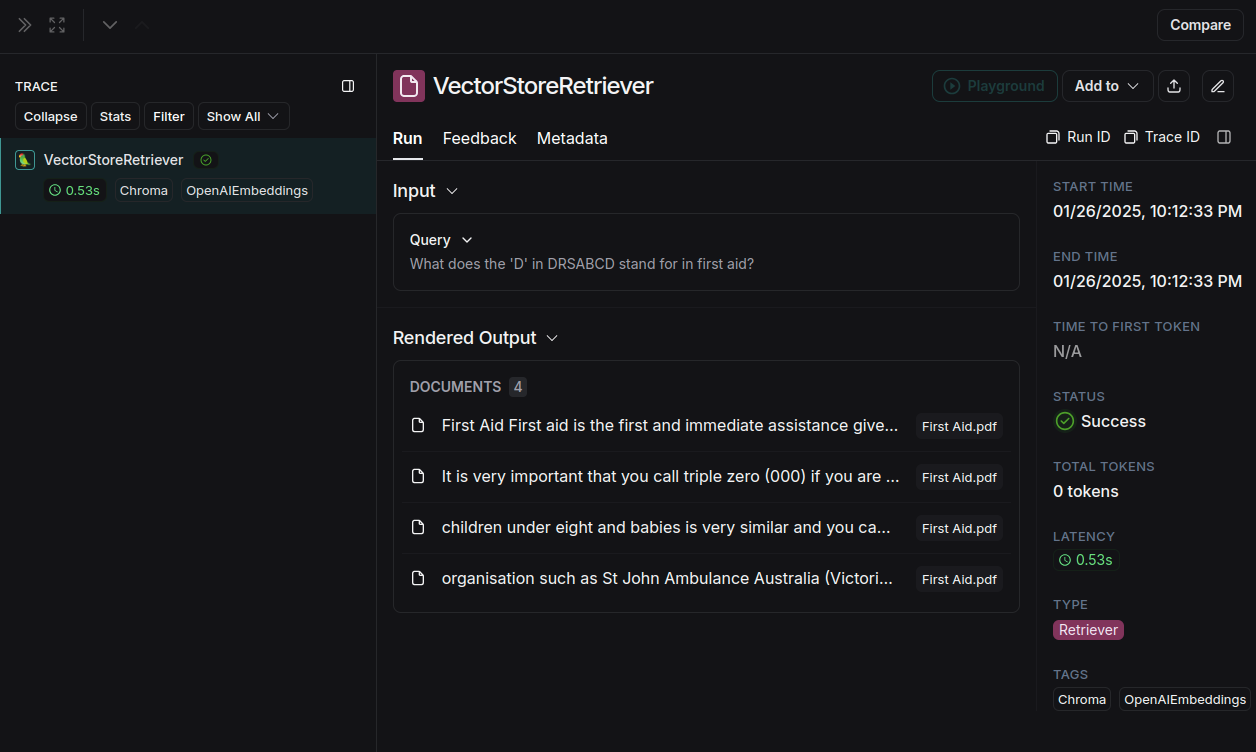

## Generation

### RAG-Fusion + Reciprocal Ranking

In [42]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [43]:
prompt_rag_fusion

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='You are a helpful assistant that generates multiple search queries based on a single input query. \n\nGenerate multiple search queries related to: {question} \n\nOutput (4 queries):'), additional_kwargs={})])

In [44]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [45]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used in the RRF formula """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": "What does the 'D' in DRSABCD stand for in first aid?"})
len(docs)

<ipython-input-45-db5547988dde>:26: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  (loads(doc), score)


5

**Process:**

1 Question --> 4 Multi-Queries --> Each retrieve relevant docs --> Rank the relevant docs and return the docs in ranked order maintaining uniqueness.

In [46]:
docs

[(Document(metadata={'source': 'First Aid.pdf'}, page_content='First Aid\nFirst aid is the first and immediate assistance given to any person with a medical\n[1]\nemergency, with care provided to preserve life, prevent the condition from\nworsening, or to promote recovery until medical services arrive. First aid is generally\nperformed by someone with basic medical or first response training.\nLearn the first aid method of DRSABCD\nFirst aid is as easy as ABC – airway, breathing and CPR (cardiopulmonary\nresuscitation). In any situation, apply the DRSABCD Action Plan.\nDRSABCD stands for:\n● Danger – always check the danger to you, any bystanders and then the\ninjured or ill person. Make sure you do not put yourself in danger when going\nto the assistance of another person.\n● Response – is the person conscious? Do they respond when you talk to them,\ntouch their hands or squeeze their shoulder?\n● Send for help – call triple zero (000). Don’t forget to answer the questions\nasked by t

STEP 1:
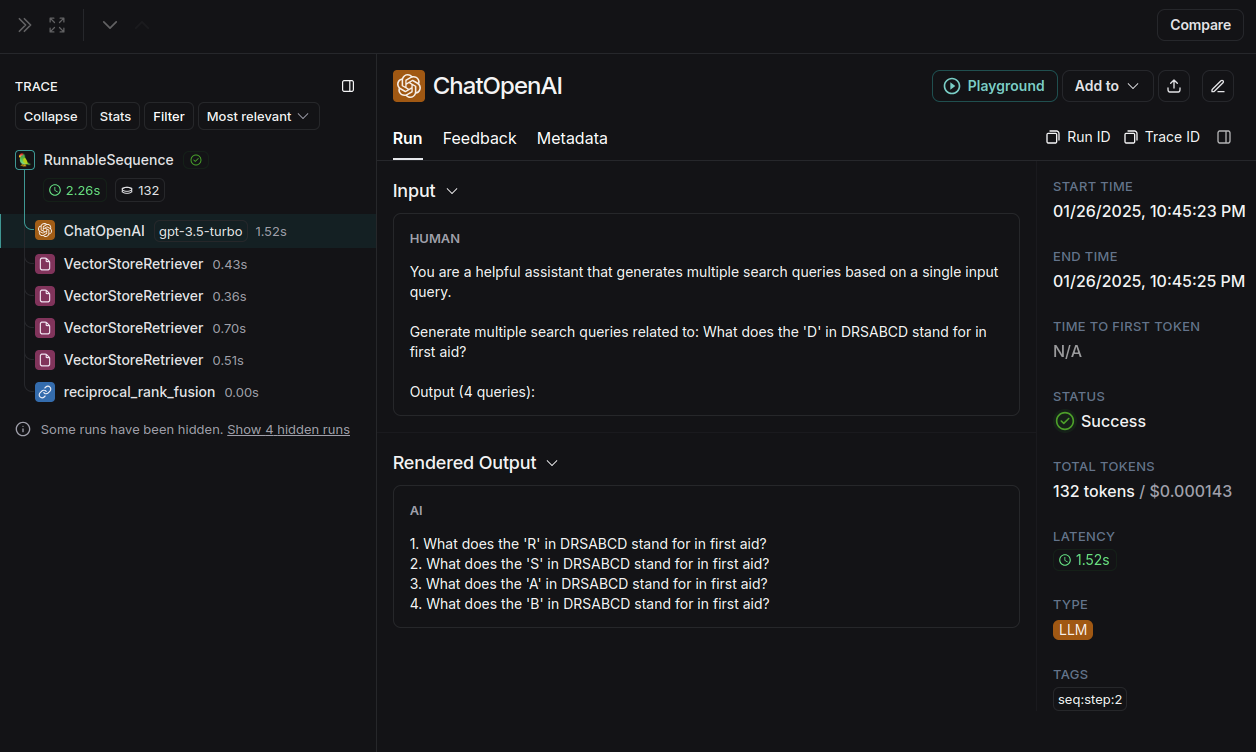

STEP 2:
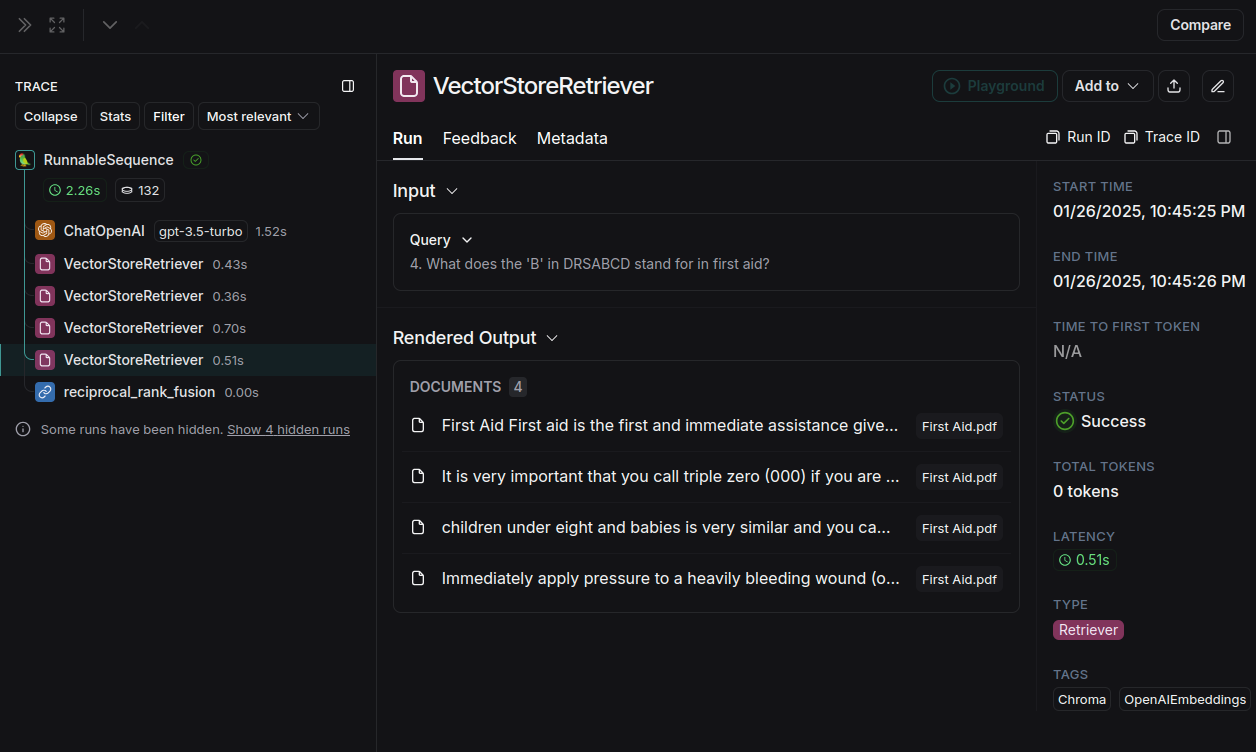

STEP 3:
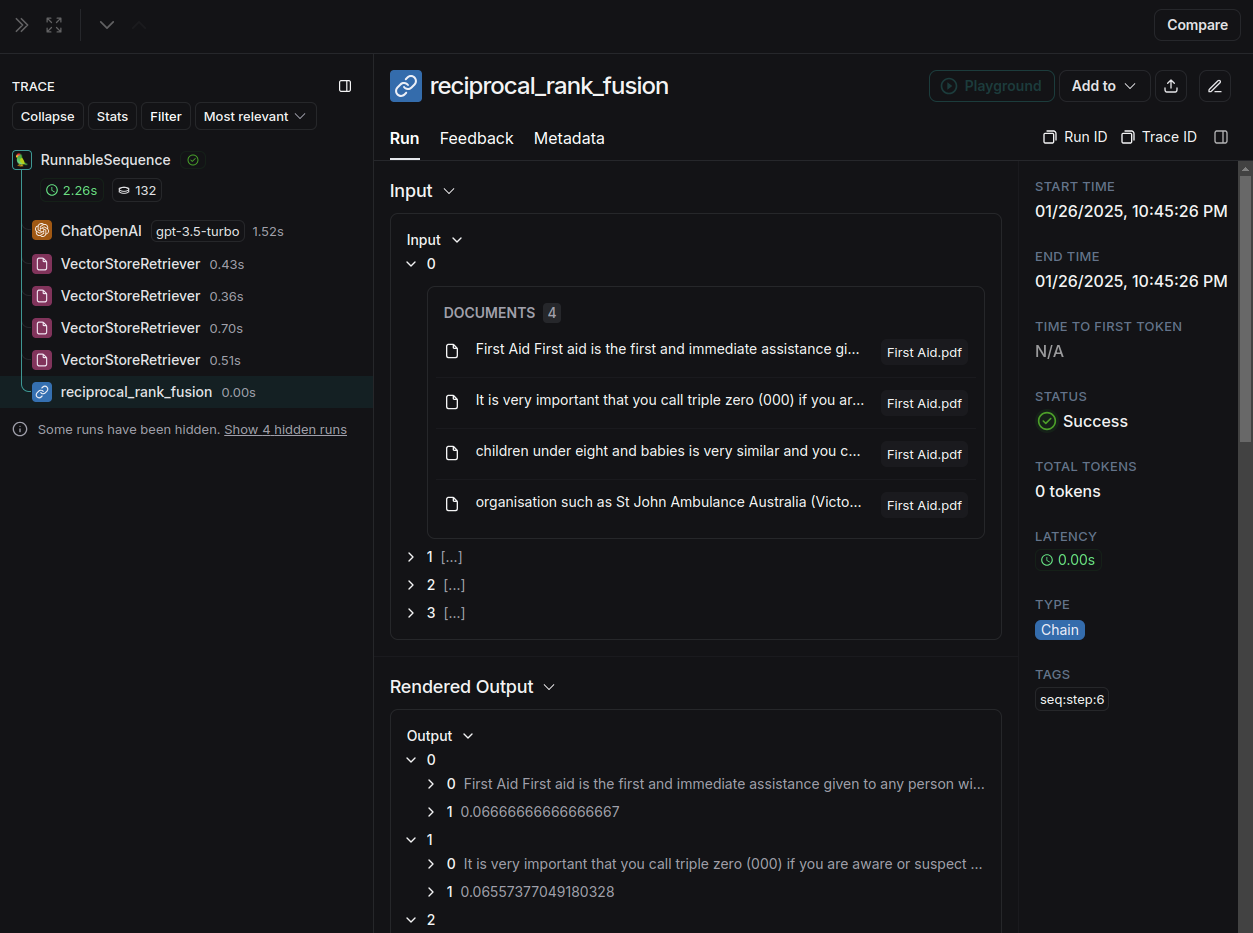

### Ranked Docs to Final Answer

In [47]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

llm = ChatOpenAI(temperature=0)

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":"What does the 'D' in DRSABCD stand for in first aid?"})

"The 'D' in DRSABCD stands for Danger."

FINAL GENERATION:
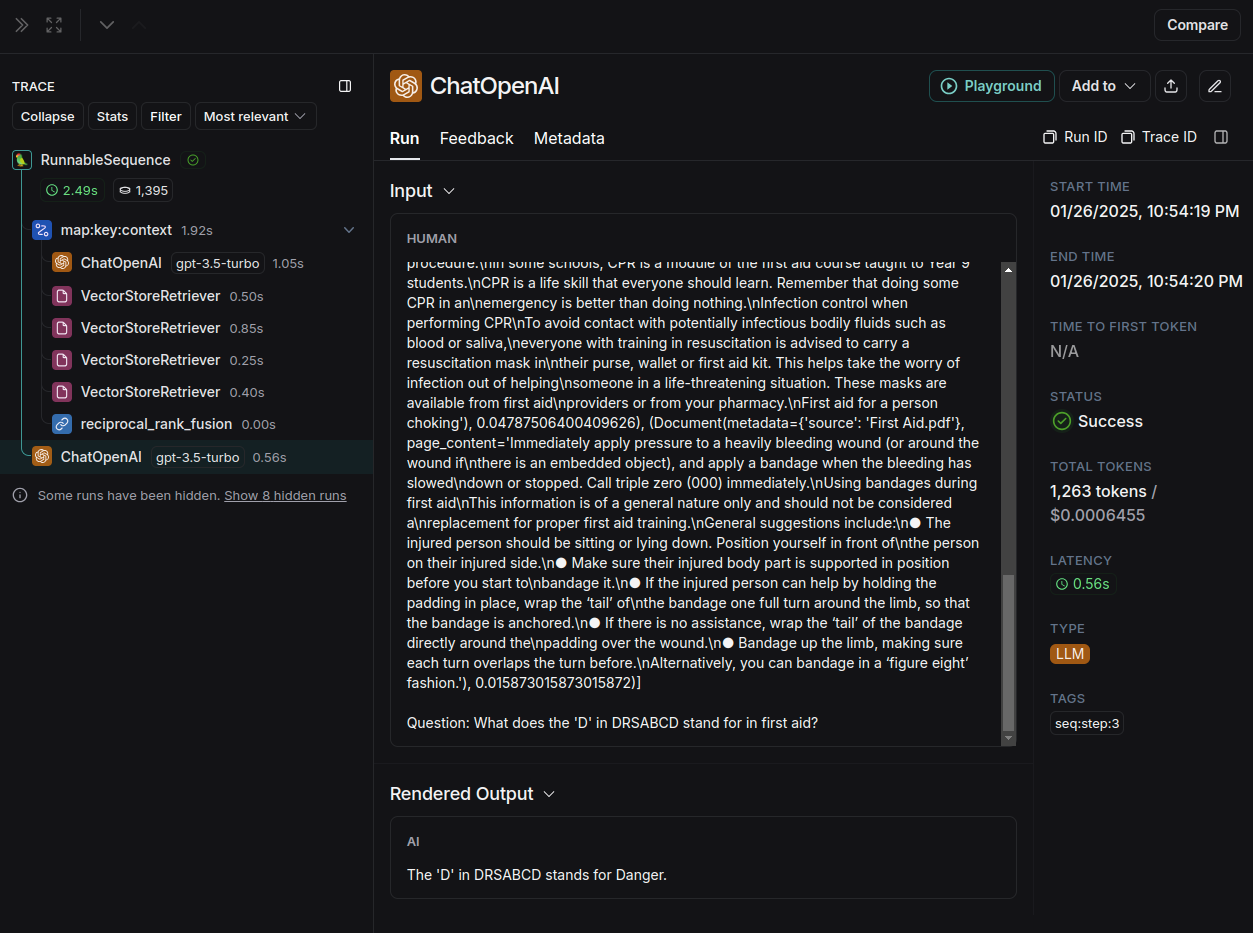

### Final Prompt - To get the output as required


EXAMPLE:
```
{“id”: 00,
   “Category”: “First Aid”,
    "question": "What does the 'D' in DRSABCD stand for in first aid?",
    "options": {
      "A": "Defibrillator",
      "B": "Danger",
      "C": "Diagnosis",
      "D": "Decision-making"
    },
    "correct_answer": "B",
    "Reasoning": "The 'D' in DRSABCD stands for Danger, which involves checking for danger to you, any bystanders, and the injured person before providing assistance."
  }

```



In [53]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

llm = ChatOpenAI(temperature=0)
question = "What does the 'D' in DRSABCD stand for in first aid?"
options = """{
    "A": "Defibrillator",
    "B": "Danger",
    "C": "Diagnosis",
    "D": "Decision-making"
  }"""

# RAG
template = """You are an expert in answering medical multiple-choice questions with reasoning.
When given a question and options, use the following context:

{context}

Respond in the following JSON format:

  {{
    'correct_answer': <correct_option>,
    'Reasoning': <reasoning explaining why the chosen option is correct>
  }}

Question: {question}

Options: {options}

Respond with the JSON output for this question.
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'options', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'options', 'question'], input_types={}, partial_variables={}, template="You are an expert in answering medical multiple-choice questions with reasoning. \nWhen given a question and options, use the following context:\n\n{context}\n\nRespond in the following JSON format:\n\n  {{\n    'correct_answer': <correct_option>,\n    'Reasoning': <reasoning explaining why the chosen option is correct>\n  }}\n\nQuestion: {question}\n\nOptions: {options}\n\nRespond with the JSON output for this question.\n"), additional_kwargs={})])

In [54]:
final_rag_chain = (
    {"context": retrieval_chain_rag_fusion,
     "question": itemgetter("question"),
     "options": itemgetter("options")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question, "options":options})

'{\n    \'correct_answer\': \'B\',\n    \'Reasoning\': \'The correct option is B: Danger. In the DRSABCD Action Plan, the "D" stands for Danger. It is important to always check the danger to yourself, any bystanders, and then the injured or ill person before providing first aid assistance.\'\n}'

FINAL TRACE

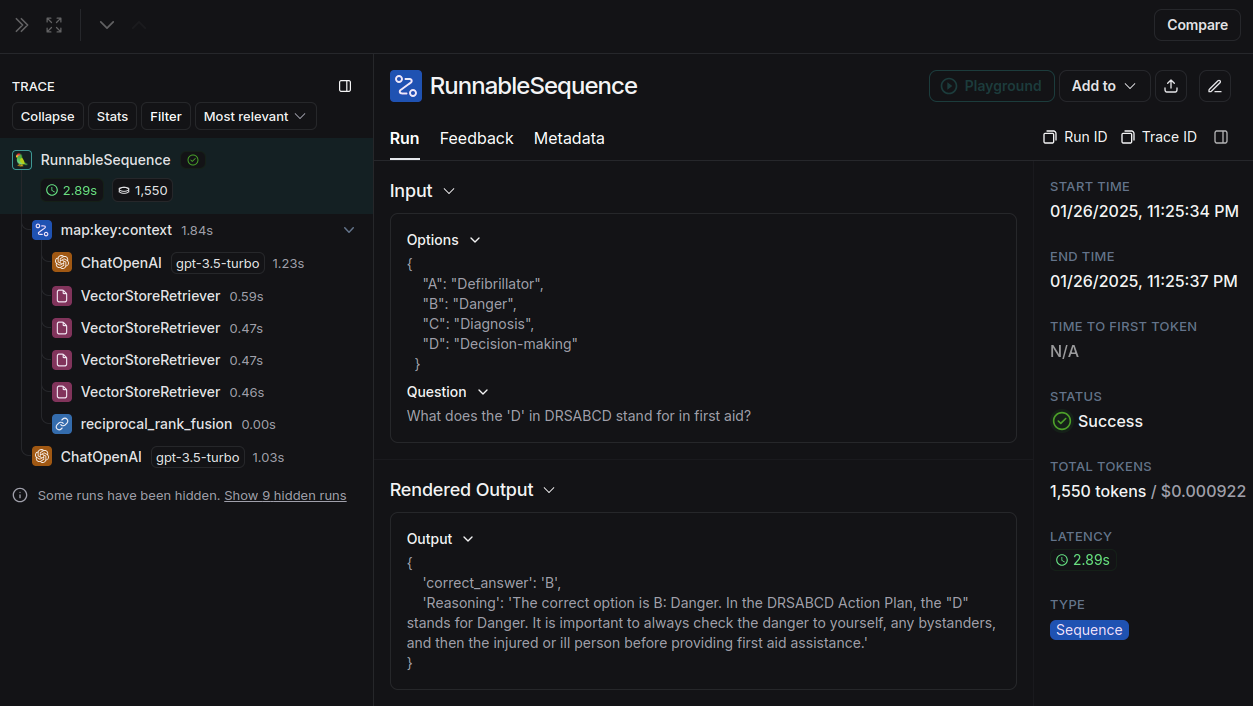

## Evaluation

### Input Dataset

In [57]:
input_data = [{"id": 0,
   "Category": "First Aid",
    "question": "What does the 'D' in DRSABCD stand for in first aid?",
    "options": {
      "A": "Defibrillator",
      "B": "Danger",
      "C": "Diagnosis",
      "D": "Decision-making"
    },
    "correct_answer": "B",
    "Reasoning": "The 'D' in DRSABCD stands for Danger, which involves checking for danger to you, any bystanders, and the injured person before providing assistance."
  },
  {"id": 1,
   "Category": "First Aid",
    "question": "If a person is unconscious and not breathing, what is the first step in performing CPR?",
    "options": {
      "A": "Call triple zero (000)",
      "B": "Check for airway obstruction",
      "C": "Perform chest compressions",
      "D": "Tilt their head back and give breaths"
    },
    "correct_answer": "C",
    "Reasoning": "For unconscious individuals not breathing, CPR involves starting with chest compressions. This ensures blood flow to vital organs."
  },
  {"id": 2,
   "Category": "First Aid",
    "question": "What is the correct action when someone is choking and their airway is not clear?",
    "options": {
      "A": "Perform a chest thrust",
      "B": "Roll them onto their side",
      "C": "Apply an AED",
      "D": "Perform CPR immediately"
    },
    "correct_answer": "B",
    "Reasoning": "If a person's airway is not clear and they are choking, rolling them onto their side is necessary to prioritize airway clearance."
  },
  {"id": 3,
   "Category": "First Aid",
    "question": "What is the main purpose of a defibrillator in first aid?",
    "options": {
      "A": "To restart a stopped heart",
      "B": "To cancel irregular heartbeats and restore normal rhythm",
      "C": "To ensure blood circulation",
      "D": "To provide oxygen to the brain"
    },
    "correct_answer": "B",
    "Reasoning": "An automated external defibrillator (AED) delivers an electrical shock to cancel arrhythmia and help re-establish a normal heartbeat."
  },
  {"id": 4,
   "Category": "First Aid",
    "question": "What should you do if a bleeding wound has an embedded object?",
    "options": {
      "A": "Remove the object immediately",
      "B": "Apply pressure around the wound",
      "C": "Clean the wound thoroughly",
      "D": "Bandage tightly over the object"
    },
    "correct_answer": "B",
    "Reasoning": "For heavily bleeding wounds with embedded objects, apply pressure around the wound without dislodging the object."
  },
  {"id": 5,
   "Category": "First Aid",
    "question": "How can you check if a bandage is too tight?",
    "options": {
      "A": "Ensure the bandage feels firm",
      "B": "Check for swelling",
      "C": "Press on a fingernail or toenail and observe the return of pink color",
      "D": "Ensure the bandage doesn't move"
    },
    "correct_answer": "C",
    "Reasoning": "To check if a bandage is too tight, press on a fingernail or toenail. If pink color returns within seconds, circulation is adequate."
  },
  {"id": 6,
   "Category": "First Aid",
    "question": "What should you do immediately after assessing that a person is unconscious but breathing?",
    "options": {
      "A": "Perform chest compressions",
      "B": "Administer a defibrillator",
      "C": "Turn them onto their side",
      "D": "Call triple zero (000)"
    },
    "correct_answer": "C",
    "Reasoning": "For an unconscious but breathing person, turn them onto their side to maintain an open airway and prevent choking."
  },
  {"id": 7,
   "Category": "First Aid",
    "question": "Which of the following is recommended to reduce the risk of infection when treating a wound?",
    "options": {
      "A": "Wash hands or use an antibacterial hand sanitiser",
      "B": "Cover the wound with a towel",
      "C": "Apply pressure to the wound",
      "D": "Avoid touching the wound directly"
    },
    "correct_answer": "A",
    "Reasoning": "Washing hands or using an antibacterial hand sanitiser helps reduce the risk of infection when managing a wound."
  },
  {"id": 8,
   "Category": "First Aid",
    "question": "What is the recommended depth of chest compressions during adult CPR?",
    "options": {
      "A": "One quarter of the chest depth",
      "B": "One third of the chest depth",
      "C": "Half the chest depth",
      "D": "Full chest depth"
    },
    "correct_answer": "B",
    "Reasoning": "Chest compressions during CPR should compress the chest to one third of its depth to ensure effective circulation."
  },
  {"id": 9,
   "Category": "First Aid",
    "question": "Why should you carry a resuscitation mask when performing CPR?",
    "options": {
      "A": "To prevent transmission of infections",
      "B": "To provide better airflow",
      "C": "To ensure oxygen supply",
      "D": "To improve chest compressions"
    },
    "correct_answer": "A",
    "Reasoning": "A resuscitation mask reduces the risk of infection transmission when performing mouth-to-mouth resuscitation."
  },
  {
    "id": 10,
    "Category": "Heart Disease",
    "question": "What is the most common type of heart disease?",
    "options": {
      "A": "Arrhythmia",
      "B": "Dilated cardiomyopathy",
      "C": "Coronary artery disease",
      "D": "Congenital heart defects"
    },
    "correct_answer": "C",
    "Reasoning": "Coronary artery disease is the most common type of heart disease, affecting the arteries that supply blood to the heart."
  },
  {
    "id": 11,
    "Category": "Heart Disease",
    "question": "Which of the following is a potential risk factor for heart disease?",
    "options": {
      "A": "Regular exercise",
      "B": "High cholesterol",
      "C": "Balanced diet",
      "D": "Low stress levels"
    },
    "correct_answer": "B",
    "Reasoning": "High cholesterol is a known risk factor for heart disease, as it can contribute to the buildup of plaque in the arteries."
  },
  {
    "id": 12,
    "Category": "Heart Disease",
    "question": "What is a common symptom of a heart attack?",
    "options": {
      "A": "Chest pain",
      "B": "Nausea",
      "C": "Sweating",
      "D": "All of the above"
    },
    "correct_answer": "D",
    "Reasoning": "Chest pain, nausea, and sweating are all common symptoms that may occur during a heart attack."
  },
  {
    "id": 13,
    "Category": "Heart Disease",
    "question": "Which medication class can help prevent blood clots in heart disease?",
    "options": {
      "A": "Beta-blockers",
      "B": "Anticoagulants",
      "C": "Cholesterol-lowering medications",
      "D": "Diuretics"
    },
    "correct_answer": "B",
    "Reasoning": "Anticoagulants, also known as blood thinners, can help prevent the formation of blood clots, reducing the risk of heart attack and stroke."
  },
  {
    "id": 14,
    "Category": "Heart Disease",
    "question": "Which heart condition is associated with a rapidly beating heart?",
    "options": {
      "A": "Bradycardia",
      "B": "Tachycardia",
      "C": "Atrial fibrillation",
      "D": "Heart failure"
    },
    "correct_answer": "B",
    "Reasoning": "Tachycardia refers to an abnormally rapid heartbeat."
  },
  {
    "id": 15,
    "Category": "Heart Disease",
    "question": "What is the primary cause of a heart attack?",
    "options": {
      "A": "Plaque buildup and blood clot in a coronary artery",
      "B": "Infection in the heart",
      "C": "Weak heart muscles",
      "D": "High blood pressure"
    },
    "correct_answer": "A",
    "Reasoning": "The most common cause of a heart attack is the buildup of plaque and a blood clot in a coronary artery, restricting blood flow to the heart muscle."
  },
  {
    "id": 16,
    "Category": "Heart Disease",
    "question": "Which condition is characterized by the thickening of the heart muscle walls?",
    "options": {
      "A": "Hypertrophic cardiomyopathy",
      "B": "Congenital heart defects",
      "C": "Coronary artery disease",
      "D": "Aortic stenosis"
    },
    "correct_answer": "A",
    "Reasoning": "Hypertrophic cardiomyopathy involves the thickening of the heart muscle walls, which can affect the heart's ability to pump blood."
  },
  {
    "id": 17,
    "Category": "Heart Disease",
    "question": "What is the main risk of arrhythmias?",
    "options": {
      "A": "Blood clots",
      "B": "Increased heart rate",
      "C": "Irregular heartbeat that could lead to heart failure",
      "D": "Heart valve issues"
    },
    "correct_answer": "C",
    "Reasoning": "Arrhythmias involve irregular heartbeats that can lead to complications like heart failure or stroke."
  },
  {
    "id": 18,
    "Category": "Heart Disease",
    "question": "What does heart failure refer to?",
    "options": {
      "A": "The heart stops beating",
      "B": "The heart's ability to pump blood is impaired",
      "C": "Excessive heart rate",
      "D": "An increase in blood pressure"
    },
    "correct_answer": "B",
    "Reasoning": "Heart failure occurs when the heart becomes weak and cannot pump blood effectively, though it may continue to beat."
  },
  {
    "id": 19,
    "Category": "Heart Disease",
    "question": "Which of these lifestyle changes can help reduce the risk of heart disease?",
    "options": {
      "A": "Regular physical activity",
      "B": "Smoking",
      "C": "High alcohol intake",
      "D": "Eating processed foods"
    },
    "correct_answer": "A",
    "Reasoning": "Regular physical activity can help improve heart health, reduce cholesterol, and manage blood pressure, all of which reduce the risk of heart disease."
  },
{
    "id": 20,
    "Category": "Diabetes",
    "question": "What is the most common type of diabetes?",
    "options": {
      "A": "Type 1 diabetes",
      "B": "Type 2 diabetes",
      "C": "Gestational diabetes",
      "D": "Maturity-onset diabetes of the young (MODY)"
    },
    "correct_answer": "B",
    "Reasoning": "Type 2 diabetes is the most common form, affecting the majority of people with diabetes."
  },
  {
    "id": 21,
    "Category": "Diabetes",
    "question": "What is the main cause of Type 2 diabetes?",
    "options": {
      "A": "Autoimmune response",
      "B": "Insulin resistance",
      "C": "Genetic mutations",
      "D": "Pancreatic damage"
    },
    "correct_answer": "B",
    "Reasoning": "Type 2 diabetes primarily results from insulin resistance, where the body’s cells don’t respond properly to insulin."
  },
  {
    "id": 22,
    "Category": "Diabetes",
    "question": "Which of the following is a symptom of diabetes?",
    "options": {
      "A": "Increased thirst",
      "B": "Low blood sugar",
      "C": "Weight gain",
      "D": "Nausea"
    },
    "correct_answer": "A",
    "Reasoning": "Increased thirst is one of the common symptoms of diabetes, especially when blood glucose levels are high."
  },
  {
    "id": 23,
    "Category": "Diabetes",
    "question": "What is prediabetes?",
    "options": {
      "A": "A stage of Type 1 diabetes",
      "B": "High blood sugar not yet at diabetes levels",
      "C": "Type 2 diabetes that develops during pregnancy",
      "D": "A rare form of diabetes"
    },
    "correct_answer": "B",
    "Reasoning": "Prediabetes refers to a condition where blood sugar levels are higher than normal but not high enough to be diagnosed as Type 2 diabetes."
  },
  {
    "id": 24,
    "Category": "Diabetes",
    "question": "What is the main difference between Type 1 and Type 2 diabetes?",
    "options": {
      "A": "Type 1 is autoimmune, while Type 2 is caused by insulin resistance",
      "B": "Type 1 occurs only in adults, while Type 2 is only in children",
      "C": "Type 1 is more common than Type 2",
      "D": "Type 2 requires insulin from the beginning, while Type 1 does not"
    },
    "correct_answer": "A",
    "Reasoning": "Type 1 diabetes is an autoimmune disease where the immune system attacks the insulin-producing cells in the pancreas, while Type 2 diabetes is primarily caused by insulin resistance."
  },
  {
    "id": 25,
    "Category": "Diabetes",
    "question": "Which type of diabetes is most commonly diagnosed during pregnancy?",
    "options": {
      "A": "Gestational diabetes",
      "B": "Type 1 diabetes",
      "C": "Type 2 diabetes",
      "D": "Type 3c diabetes"
    },
    "correct_answer": "A",
    "Reasoning": "Gestational diabetes develops during pregnancy and typically resolves after childbirth, although it increases the risk of developing Type 2 diabetes later in life."
  },
  {
    "id": 26,
    "Category": "Diabetes",
    "question": "Which of the following conditions can lead to Type 3c diabetes?",
    "options": {
      "A": "Autoimmune destruction of the pancreas",
      "B": "Pancreatic damage from conditions like pancreatitis",
      "C": "Insulin resistance",
      "D": "Gestational diabetes"
    },
    "correct_answer": "B",
    "Reasoning": "Type 3c diabetes occurs when the pancreas is damaged by conditions like pancreatitis or pancreatic cancer, affecting its ability to produce insulin."
  },
  {
    "id": 27,
    "Category": "Diabetes",
    "question": "What is the most common complication of long-term diabetes?",
    "options": {
      "A": "Nerve damage",
      "B": "Hypoglycemia",
      "C": "Heart disease",
      "D": "Kidney failure"
    },
    "correct_answer": "C",
    "Reasoning": "Cardiovascular issues, such as heart disease, are the most common long-term complications of diabetes due to damage to blood vessels."
  },
  {
    "id": 28,
    "Category": "Diabetes",
    "question": "Which test is commonly used to monitor long-term blood glucose levels?",
    "options": {
      "A": "Fasting blood glucose test",
      "B": "Random blood glucose test",
      "C": "A1c (HbA1c) test",
      "D": "Oral glucose tolerance test"
    },
    "correct_answer": "C",
    "Reasoning": "The A1c test provides an average of your blood glucose levels over the past two to three months, helping to monitor long-term control of diabetes."
  },
  {
    "id": 29,
    "Category": "Diabetes",
    "question": "What is the main cause of diabetic ketoacidosis (DKA)?",
    "options": {
      "A": "Insulin resistance",
      "B": "High blood glucose and lack of insulin",
      "C": "Too much insulin",
      "D": "Pancreatic failure"
    },
    "correct_answer": "B",
    "Reasoning": "DKA occurs when the body doesn’t have enough insulin to use glucose for energy, leading to fat breakdown and the buildup of acidic ketones in the blood."
  },
{
    "id": 30,
    "Category": "Asthma",
    "question": "What is asthma?",
    "options": {
      "A": "A disease that affects the heart",
      "B": "A disease that affects your lungs",
      "C": "A disease that causes skin rashes",
      "D": "A temporary condition that resolves itself"
    },
    "correct_answer": "B",
    "Reasoning": "Asthma is a chronic disease that affects the lungs, causing difficulty in breathing."
  },
  {
    "id": 31,
    "Category": "Asthma",
    "question": "What is an asthma attack?",
    "options": {
      "A": "A sudden worsening of asthma symptoms",
      "B": "A sudden improvement in asthma symptoms",
      "C": "A condition where airways become overly relaxed",
      "D": "An allergic reaction affecting the skin"
    },
    "correct_answer": "A",
    "Reasoning": "An asthma attack occurs when the airways constrict, swell, and produce excess mucus, making breathing difficult."
  },
  {
    "id": 32,
    "Category": "Asthma",
    "question": "Which of the following is NOT a type of asthma?",
    "options": {
      "A": "Exercise-induced asthma",
      "B": "Occupational asthma",
      "C": "Allergic asthma",
      "D": "Cold-induced asthma"
    },
    "correct_answer": "D",
    "Reasoning": "Cold-induced asthma is not recognized as a distinct type of asthma, although cold air can be a trigger for asthma."
  },
  {
    "id": 33,
    "Category": "Asthma",
    "question": "Which factor is a common cause of asthma?",
    "options": {
      "A": "Exposure to mold",
      "B": "Lack of physical activity",
      "C": "Cold weather",
      "D": "Frequent exercise"
    },
    "correct_answer": "A",
    "Reasoning": "Exposure to mold, among other allergens, is a common environmental trigger that can cause asthma attacks."
  },
  {
    "id": 34,
    "Category": "Asthma",
    "question": "Which of the following is a symptom of asthma?",
    "options": {
      "A": "Fever",
      "B": "Wheezing",
      "C": "Rashes",
      "D": "Frequent headaches"
    },
    "correct_answer": "B",
    "Reasoning": "Wheezing, or a high-pitched sound when breathing out, is a common symptom of asthma."
  },
  {
    "id": 35,
    "Category": "Asthma",
    "question": "What is the main goal of asthma treatment?",
    "options": {
      "A": "To cure asthma completely",
      "B": "To control symptoms and prevent attacks",
      "C": "To eliminate the need for medication",
      "D": "To increase lung capacity"
    },
    "correct_answer": "B",
    "Reasoning": "The goal of asthma treatment is to control symptoms and prevent asthma attacks, not to cure asthma completely."
  },
  {
    "id": 36,
    "Category": "Asthma",
    "question": "What can help prevent an asthma attack?",
    "options": {
      "A": "Avoiding asthma triggers",
      "B": "Increasing exposure to cold weather",
      "C": "Exercising excessively",
      "D": "Ignoring asthma symptoms"
    },
    "correct_answer": "A",
    "Reasoning": "Avoiding asthma triggers is key in preventing asthma attacks, as triggers can provoke symptoms and exacerbations."
  },
  {
    "id": 37,
    "Category": "Asthma",
    "question": "What is a peak flow meter used for?",
    "options": {
      "A": "To measure the temperature of your body",
      "B": "To measure airflow through your lungs",
      "C": "To check blood oxygen levels",
      "D": "To check lung size"
    },
    "correct_answer": "B",
    "Reasoning": "A peak flow meter measures how fast you can blow air out of your lungs, which helps monitor asthma symptoms and manage treatment."
  },
  {
    "id": 38,
    "Category": "Asthma",
    "question": "What should you do if you have a severe asthma attack?",
    "options": {
      "A": "Use your rescue inhaler and seek medical help if needed",
      "B": "Wait for the symptoms to go away on their own",
      "C": "Take an over-the-counter cold medicine",
      "D": "Increase physical activity"
    },
    "correct_answer": "A",
    "Reasoning": "During a severe asthma attack, you should use your rescue inhaler immediately and seek emergency medical care if symptoms persist."
  },
  {
    "id": 39,
    "Category": "Asthma",
    "question": "Can asthma be cured?",
    "options": {
      "A": "Yes, with medication",
      "B": "Yes, through surgery",
      "C": "No, but it can be managed",
      "D": "Yes, with physical therapy"
    },
    "correct_answer": "C",
    "Reasoning": "Asthma cannot be cured, but it can be managed through medication, lifestyle adjustments, and avoiding triggers."
  },
{
    "id": 40,
    "Category": "Stroke",
    "question": "What is the primary cause of ischemic strokes?",
    "options": {
      "A": "Bleeding in the brain",
      "B": "Blockage of blood vessels in the brain",
      "C": "Aneurysm in the brain",
      "D": "High blood pressure"
    },
    "correct_answer": "B",
    "Reasoning": "Ischemic strokes are caused by a blockage in the blood vessels of the brain, leading to a lack of blood flow and oxygen."
  },
  {
    "id": 41,
    "Category": "Stroke",
    "question": "What does the acronym BE FAST help you remember?",
    "options": {
      "A": "The stages of stroke recovery",
      "B": "The emergency response steps for a heart attack",
      "C": "The symptoms of a stroke",
      "D": "The signs of a heart attack"
    },
    "correct_answer": "C",
    "Reasoning": "BE FAST helps to remember the key symptoms of a stroke: Balance, Eyes, Face, Arms, Speech, and Time."
  },
  {
    "id": 42,
    "Category": "Stroke",
    "question": "What is a transient ischemic attack (TIA)?",
    "options": {
      "A": "A stroke that lasts for a week",
      "B": "A type of hemorrhagic stroke",
      "C": "A mini-stroke with temporary effects",
      "D": "A severe headache caused by stroke"
    },
    "correct_answer": "C",
    "Reasoning": "A TIA, or mini-stroke, has temporary effects and is often a warning sign of a higher risk of a full stroke."
  },
  {
    "id": 43,
    "Category": "Stroke",
    "question": "Which of the following is a primary risk factor for stroke?",
    "options": {
      "A": "Sleep apnea",
      "B": "Obesity",
      "C": "High blood pressure",
      "D": "All of the above"
    },
    "correct_answer": "D",
    "Reasoning": "High blood pressure, obesity, and sleep apnea are all risk factors that increase the likelihood of having a stroke."
  },
  {
    "id": 44,
    "Category": "Stroke",
    "question": "What is the first treatment priority for an ischemic stroke?",
    "options": {
      "A": "Surgery",
      "B": "Restoring blood flow",
      "C": "Managing blood pressure",
      "D": "Controlling bleeding"
    },
    "correct_answer": "B",
    "Reasoning": "For ischemic strokes, the primary treatment is restoring blood flow to the affected brain area to minimize damage."
  },
  {
    "id": 45,
    "Category": "Stroke",
    "question": "Which type of stroke involves bleeding inside the brain?",
    "options": {
      "A": "Ischemic stroke",
      "B": "Hemorrhagic stroke",
      "C": "Transient ischemic attack",
      "D": "Cryptogenic stroke"
    },
    "correct_answer": "B",
    "Reasoning": "Hemorrhagic strokes involve bleeding inside or around the brain, leading to pressure on brain tissue."
  },
  {
    "id": 46,
    "Category": "Stroke",
    "question": "What is a common symptom of a stroke related to the face?",
    "options": {
      "A": "Blurred vision",
      "B": "Loss of coordination",
      "C": "Drooping on one side of the face",
      "D": "Sudden memory loss"
    },
    "correct_answer": "C",
    "Reasoning": "A drooping face on one side is a common symptom of muscle weakness or paralysis in stroke patients."
  },
  {
    "id": 47,
    "Category": "Stroke",
    "question": "What diagnostic test is commonly used to confirm a stroke?",
    "options": {
      "A": "Electrocardiogram (ECG)",
      "B": "Magnetic resonance imaging (MRI)",
      "C": "Blood tests",
      "D": "Ultrasound"
    },
    "correct_answer": "B",
    "Reasoning": "Magnetic resonance imaging (MRI) is commonly used to diagnose strokes by providing detailed images of the brain."
  },
  {
    "id": 48,
    "Category": "Stroke",
    "question": "What is the purpose of thrombolytic drugs in ischemic stroke treatment?",
    "options": {
      "A": "To reduce brain pressure",
      "B": "To dissolve blood clots",
      "C": "To control blood sugar",
      "D": "To stop brain bleeding"
    },
    "correct_answer": "B",
    "Reasoning": "Thrombolytic drugs dissolve blood clots and help restore circulation to the affected brain area during an ischemic stroke."
  },
  {
    "id": 49,
    "Category": "Stroke",
    "question": "What lifestyle change can help reduce the risk of stroke?",
    "options": {
      "A": "Smoking cessation",
      "B": "Regular exercise",
      "C": "Healthy diet",
      "D": "All of the above"
    },
    "correct_answer": "D",
    "Reasoning": "Smoking cessation, regular exercise, and a healthy diet are all effective ways to reduce stroke risk."
  },
 {
    "id": 50,
    "Category": "Breast Cancer",
    "question": "What is the most common type of breast cancer in the United States?",
    "options": {
      "A": "Lobular breast cancer",
      "B": "Invasive (infiltrating) ductal carcinoma (IDC)",
      "C": "Triple-negative breast cancer (TNBC)",
      "D": "Paget’s disease of the breast"
    },
    "correct_answer": "B",
    "Reasoning": "Invasive ductal carcinoma (IDC) is the most common type of breast cancer in the United States, starting in the milk ducts and spreading to nearby breast tissue."
  },
  {
    "id": 51,
    "Category": "Breast Cancer",
    "question": "Which of the following is a less common type of breast cancer?",
    "options": {
      "A": "Lobular breast cancer",
      "B": "Inflammatory breast cancer (IBC)",
      "C": "Invasive (infiltrating) ductal carcinoma (IDC)",
      "D": "Ductal carcinoma in situ (DCIS)"
    },
    "correct_answer": "B",
    "Reasoning": "Inflammatory breast cancer (IBC) is rare and grows quickly, often appearing like a rash on the breast."
  },
  {
    "id": 52,
    "Category": "Breast Cancer",
    "question": "What does it mean if breast cancer is classified as HR-positive?",
    "options": {
      "A": "The cancer cells have estrogen and progesterone receptors.",
      "B": "The cancer cells have HER2 protein.",
      "C": "The cancer cells don’t have estrogen or progesterone receptors.",
      "D": "The cancer cells do not spread to other parts of the body."
    },
    "correct_answer": "A",
    "Reasoning": "HR-positive breast cancers have estrogen and progesterone receptors, which help cancer cells to grow when these hormones are present."
  },
  {
    "id": 53,
    "Category": "Breast Cancer",
    "question": "At what age is breast cancer most likely to affect women and people AFAB?",
    "options": {
      "A": "Under age 30",
      "B": "Between ages 30 and 40",
      "C": "50 and older",
      "D": "Between ages 40 and 50"
    },
    "correct_answer": "C",
    "Reasoning": "Breast cancer typically affects women and people AFAB age 50 and older, but it can also affect younger individuals."
  },
  {
    "id": 54,
    "Category": "Breast Cancer",
    "question": "What is a common symptom of breast cancer?",
    "options": {
      "A": "Pain in the back",
      "B": "A lump or thickening in or near the breast or underarm",
      "C": "Frequent headaches",
      "D": "Difficulty breathing"
    },
    "correct_answer": "B",
    "Reasoning": "A lump or thickening in or near the breast or underarm that persists through the menstrual cycle is a common symptom of breast cancer."
  },
  {
    "id": 55,
    "Category": "Breast Cancer",
    "question": "Which of the following is a risk factor for developing breast cancer?",
    "options": {
      "A": "Being under age 30",
      "B": "Family history of breast cancer",
      "C": "Lack of physical activity",
      "D": "Consuming only plant-based foods"
    },
    "correct_answer": "B",
    "Reasoning": "Having a family history of breast cancer increases the risk of developing the condition, as inherited genetic mutations are a known risk factor."
  },
  {
    "id": 56,
    "Category": "Breast Cancer",
    "question": "What does a breast cancer stage of Stage IV indicate?",
    "options": {
      "A": "The cancer is localized to the breast.",
      "B": "The cancer has spread to nearby tissue and lymph nodes.",
      "C": "The cancer has spread to distant areas such as bones, liver, or lungs.",
      "D": "The cancer is in situ and hasn’t spread."
    },
    "correct_answer": "C",
    "Reasoning": "Stage IV indicates metastatic breast cancer, where the cancer has spread to distant areas such as bones, liver, or lungs."
  },
  {
    "id": 57,
    "Category": "Breast Cancer",
    "question": "Which breast cancer subtype is associated with higher levels of the HER2 protein?",
    "options": {
      "A": "HR-negative",
      "B": "HER2-positive",
      "C": "ER-positive",
      "D": "PR-positive"
    },
    "correct_answer": "B",
    "Reasoning": "HER2-positive breast cancers have higher than normal levels of the HER2 protein, which helps cancer cells grow."
  },
  {
    "id": 58,
    "Category": "Breast Cancer",
    "question": "What is a possible complication of breast cancer surgery?",
    "options": {
      "A": "Hair loss",
      "B": "Nerve damage",
      "C": "Vision loss",
      "D": "Memory loss"
    },
    "correct_answer": "B",
    "Reasoning": "Nerve damage is a possible complication of breast cancer surgery, along with other risks such as infection and blood clots."
  },
  {
    "id": 59,
    "Category": "Breast Cancer",
    "question": "What is one way to lower the risk of breast cancer?",
    "options": {
      "A": "Smoking",
      "B": "Regular physical activity",
      "C": "Eating a high-fat diet",
      "D": "Drinking alcohol daily"
    },
    "correct_answer": "B",
    "Reasoning": "Regular physical activity has been shown to lower the risk of developing breast cancer."
  },
{
    "id": 60,
    "Category": "Migraine",
    "question": "What is a migraine?",
    "options": {
      "A": "A type of stress-related condition",
      "B": "A severe headache with throbbing, pulsing pain",
      "C": "A headache caused by dehydration",
      "D": "A tension headache"
    },
    "correct_answer": "B",
    "Reasoning": "A migraine is a severe headache that causes throbbing, pulsing head pain, usually on one side of the head."
  },
  {
    "id": 61,
    "Category": "Migraine",
    "question": "How long does the headache phase of a migraine usually last?",
    "options": {
      "A": "One hour",
      "B": "Four hours to 72 hours",
      "C": "A few minutes",
      "D": "One week"
    },
    "correct_answer": "B",
    "Reasoning": "The headache phase of a migraine usually lasts at least four hours but can last up to 72 hours."
  },
  {
    "id": 62,
    "Category": "Migraine",
    "question": "What is the first phase of a migraine?",
    "options": {
      "A": "Aura",
      "B": "Headache",
      "C": "Prodrome",
      "D": "Postdrome"
    },
    "correct_answer": "C",
    "Reasoning": "The first phase of a migraine is called the prodrome, which can begin up to 24 hours before the headache."
  },
  {
    "id": 63,
    "Category": "Migraine",
    "question": "Which of the following is NOT a phase of a migraine?",
    "options": {
      "A": "Prodrome",
      "B": "Aura",
      "C": "Postdrome",
      "D": "Interdrome"
    },
    "correct_answer": "D",
    "Reasoning": "The phases of a migraine include prodrome, aura, headache, and postdrome. There is no phase called 'interdrome.'"
  },
  {
    "id": 64,
    "Category": "Migraine",
    "question": "Which migraine symptom occurs in the postdrome phase?",
    "options": {
      "A": "Muscle weakness",
      "B": "Numbness and tingling",
      "C": "Fatigue",
      "D": "Vision changes"
    },
    "correct_answer": "C",
    "Reasoning": "Fatigue is a common symptom in the postdrome phase, which can also feel similar to an alcohol-induced hangover."
  },
  {
    "id": 65,
    "Category": "Migraine",
    "question": "What is the common duration of a migraine headache?",
    "options": {
      "A": "Less than one hour",
      "B": "One to two hours",
      "C": "Four hours to 72 hours",
      "D": "A week"
    },
    "correct_answer": "C",
    "Reasoning": "A migraine headache typically lasts from four hours to 72 hours."
  },
  {
    "id": 66,
    "Category": "Migraine",
    "question": "What is the most common type of migraine?",
    "options": {
      "A": "Migraine with aura",
      "B": "Migraine without aura",
      "C": "Menstrual migraine",
      "D": "Chronic migraine"
    },
    "correct_answer": "B",
    "Reasoning": "Migraine without aura (common migraine) is the most prevalent type of migraine."
  },
  {
    "id": 67,
    "Category": "Migraine",
    "question": "Which of the following is a known trigger for migraines?",
    "options": {
      "A": "Bright lights",
      "B": "Physical activity",
      "C": "Loud noises",
      "D": "All of the above"
    },
    "correct_answer": "D",
    "Reasoning": "Bright lights, physical activity, and loud noises are all common migraine triggers."
  },
  {
    "id": 68,
    "Category": "Migraine",
    "question": "What percentage of people with migraines have a first-degree relative with the condition?",
    "options": {
      "A": "10%",
      "B": "20%",
      "C": "50%",
      "D": "Up to 80%"
    },
    "correct_answer": "D",
    "Reasoning": "Up to 80% of people with migraines have a first-degree biological relative with the condition."
  },
  {
    "id": 69,
    "Category": "Migraine",
    "question": "Which of the following medications is commonly used to stop a migraine?",
    "options": {
      "A": "Beta-blockers",
      "B": "Triptans",
      "C": "Antiseizure medications",
      "D": "Monoclonal antibodies"
    },
    "correct_answer": "B",
    "Reasoning": "Triptans are commonly used medications to stop a migraine when it begins."
  },
{
    "id": 70,
    "Category": "Celiac Disease",
    "question": "What triggers the immune system response in people with celiac disease?",
    "options": {
      "A": "Bacterial infections",
      "B": "Gluten",
      "C": "Vitamin deficiencies",
      "D": "High blood pressure"
    },
    "correct_answer": "B",
    "Reasoning": "Gluten triggers an immune system response in people with celiac disease, causing damage to the small intestine."
  },
  {
    "id": 71,
    "Category": "Celiac Disease",
    "question": "What is the primary function of the small intestine that is affected by celiac disease?",
    "options": {
      "A": "Production of digestive enzymes",
      "B": "Absorption of nutrients",
      "C": "Production of bile",
      "D": "Absorption of oxygen"
    },
    "correct_answer": "B",
    "Reasoning": "The primary function of the small intestine is nutrient absorption, which is impaired in celiac disease due to damage to the mucosa."
  },
  {
    "id": 72,
    "Category": "Celiac Disease",
    "question": "Which of the following is NOT a common symptom of celiac disease?",
    "options": {
      "A": "Stomach pain",
      "B": "Fatigue",
      "C": "Bloating",
      "D": "Excessive thirst"
    },
    "correct_answer": "D",
    "Reasoning": "Excessive thirst is not a typical symptom of celiac disease, whereas stomach pain, fatigue, and bloating are common."
  },
  {
    "id": 73,
    "Category": "Celiac Disease",
    "question": "What gene mutations are commonly associated with celiac disease?",
    "options": {
      "A": "BRCA1 and BRCA2",
      "B": "HLA-DQ2 and HLA-DQ8",
      "C": "APOE4",
      "D": "TP53"
    },
    "correct_answer": "B",
    "Reasoning": "The gene mutations HLA-DQ2 and HLA-DQ8 are commonly associated with celiac disease."
  },
  {
    "id": 74,
    "Category": "Celiac Disease",
    "question": "What is the most important part of treating celiac disease?",
    "options": {
      "A": "Taking corticosteroids",
      "B": "Starting a gluten-free diet",
      "C": "Receiving regular blood transfusions",
      "D": "Engaging in regular exercise"
    },
    "correct_answer": "B",
    "Reasoning": "The most important treatment for celiac disease is maintaining a strict gluten-free diet to prevent further immune system damage."
  },
  {
    "id": 75,
    "Category": "Celiac Disease",
    "question": "At what age is celiac disease most commonly diagnosed?",
    "options": {
      "A": "Early childhood (8-12 months)",
      "B": "Adolescence (13-18 years)",
      "C": "Mid-life (40-60 years)",
      "D": "Late adulthood (60+ years)"
    },
    "correct_answer": "A",
    "Reasoning": "Celiac disease is commonly diagnosed in early childhood, typically when solid foods containing gluten are introduced."
  },
  {
    "id": 76,
    "Category": "Celiac Disease",
    "question": "What chronic skin condition is associated with celiac disease?",
    "options": {
      "A": "Psoriasis",
      "B": "Dermatitis herpetiformis",
      "C": "Eczema",
      "D": "Rosacea"
    },
    "correct_answer": "B",
    "Reasoning": "Dermatitis herpetiformis, also known as the 'gluten rash,' is a chronic skin condition associated with celiac disease."
  },
  {
    "id": 77,
    "Category": "Celiac Disease",
    "question": "Which of the following is a common complication of untreated celiac disease?",
    "options": {
      "A": "Hypertension",
      "B": "Osteoporosis",
      "C": "Asthma",
      "D": "Liver failure"
    },
    "correct_answer": "B",
    "Reasoning": "Osteoporosis is a common complication of untreated celiac disease due to malabsorption of calcium and other nutrients."
  },
  {
    "id": 78,
    "Category": "Celiac Disease",
    "question": "What is the primary cause of damage to the small intestine in people with celiac disease?",
    "options": {
      "A": "Bacterial infections",
      "B": "Immune system attack triggered by gluten",
      "C": "Lack of stomach acid",
      "D": "Poor blood circulation"
    },
    "correct_answer": "B",
    "Reasoning": "The immune system attacks the small intestine in response to gluten, causing damage to the mucosa."
  },
  {
    "id": 79,
    "Category": "Celiac Disease",
    "question": "Which of the following foods typically contains gluten and should be avoided by individuals with celiac disease?",
    "options": {
      "A": "Rice",
      "B": "Corn",
      "C": "Wheat",
      "D": "Potatoes"
    },
    "correct_answer": "C",
    "Reasoning": "Wheat contains gluten, which triggers a response in individuals with celiac disease."
  },
{
    "id": 80,
    "Category": "Skin Diseases",
    "question": "What is the largest organ in the human body?",
    "options": {
      "A": "Heart",
      "B": "Liver",
      "C": "Skin",
      "D": "Lungs"
    },
    "correct_answer": "C",
    "Reasoning": "The skin is the largest organ in the human body, covering and protecting the body."
  },
  {
    "id": 81,
    "Category": "Skin Diseases",
    "question": "What is acne caused by?",
    "options": {
      "A": "Bacterial infection",
      "B": "Blocked skin follicles",
      "C": "Excessive sweating",
      "D": "Skin cancer"
    },
    "correct_answer": "B",
    "Reasoning": "Acne is caused by blocked skin follicles, which lead to oil, bacteria, and dead skin buildup."
  },
  {
    "id": 82,
    "Category": "Skin Diseases",
    "question": "Which of the following skin diseases leads to hair loss in small patches?",
    "options": {
      "A": "Psoriasis",
      "B": "Alopecia areata",
      "C": "Rosacea",
      "D": "Eczema"
    },
    "correct_answer": "B",
    "Reasoning": "Alopecia areata is a condition that causes hair loss in small patches, often affecting the scalp."
  },
  {
    "id": 83,
    "Category": "Skin Diseases",
    "question": "Which condition is characterized by dry, itchy skin leading to swelling and cracking?",
    "options": {
      "A": "Psoriasis",
      "B": "Atopic dermatitis (eczema)",
      "C": "Vitiligo",
      "D": "Rosacea"
    },
    "correct_answer": "B",
    "Reasoning": "Atopic dermatitis, also known as eczema, causes dry, itchy skin that can lead to swelling, cracking, or scaliness."
  },
  {
    "id": 84,
    "Category": "Skin Diseases",
    "question": "What is the condition where skin patches lose pigment?",
    "options": {
      "A": "Vitiligo",
      "B": "Acne",
      "C": "Psoriasis",
      "D": "Rosacea"
    },
    "correct_answer": "A",
    "Reasoning": "Vitiligo is a condition in which patches of skin lose their pigment, leading to lighter skin areas."
  },
  {
    "id": 85,
    "Category": "Skin Diseases",
    "question": "Which of the following skin diseases is rare and characterized by fragile skin that blisters easily?",
    "options": {
      "A": "Actinic prurigo",
      "B": "Epidermolysis bullosa",
      "C": "Necrobiosis lipoidica",
      "D": "Harlequin ichthyosis"
    },
    "correct_answer": "B",
    "Reasoning": "Epidermolysis bullosa is a rare genetic disorder that causes fragile skin, which blisters and tears easily."
  },
  {
    "id": 86,
    "Category": "Skin Diseases",
    "question": "What is one common cause of skin diseases?",
    "options": {
      "A": "Sun exposure",
      "B": "Lack of sleep",
      "C": "Cold weather",
      "D": "Drinking alcohol"
    },
    "correct_answer": "A",
    "Reasoning": "Sun exposure can lead to various skin conditions, including sunburn and skin cancer, which are common causes of skin diseases."
  },
  {
    "id": 87,
    "Category": "Skin Diseases",
    "question": "Which test involves removing a small piece of skin to examine under a microscope?",
    "options": {
      "A": "Culture",
      "B": "Biopsy",
      "C": "Skin patch test",
      "D": "Dermoscopy"
    },
    "correct_answer": "B",
    "Reasoning": "A biopsy involves removing a small piece of skin tissue to examine it for potential skin diseases."
  },
  {
    "id": 88,
    "Category": "Skin Diseases",
    "question": "What is one way to prevent contagious skin diseases?",
    "options": {
      "A": "Avoiding sun exposure",
      "B": "Not sharing personal items",
      "C": "Using moisturizers",
      "D": "Taking antibiotics"
    },
    "correct_answer": "B",
    "Reasoning": "Avoiding sharing personal items, such as cosmetics or towels, can help prevent the spread of contagious skin diseases."
  },
  {
    "id": 89,
    "Category": "Skin Diseases",
    "question": "Which condition causes periodic reduced blood flow to fingers and toes, causing numbness and color change?",
    "options": {
      "A": "Raynaud's phenomenon",
      "B": "Psoriasis",
      "C": "Alopecia areata",
      "D": "Eczema"
    },
    "correct_answer": "A",
    "Reasoning": "Raynaud's phenomenon is a condition that causes periodic reduced blood flow to the fingers, toes, or other body parts, leading to numbness or skin color change."
  },
 {
    "id": 90,
    "Category": "Lung Disease",
    "question": "What is the most common cause of chronic obstructive pulmonary disease (COPD)?",
    "options": {
      "A": "Asthma",
      "B": "Smoking",
      "C": "Bacterial infection",
      "D": "Genetic mutation"
    },
    "correct_answer": "B",
    "Reasoning": "Smoking is the leading cause of chronic obstructive pulmonary disease (COPD), which causes long-term damage to the airways and alveoli."
  },
  {
    "id": 91,
    "Category": "Lung Disease",
    "question": "What is the primary symptom of asthma?",
    "options": {
      "A": "Wheezing",
      "B": "Coughing",
      "C": "Shortness of breath",
      "D": "Chest pain"
    },
    "correct_answer": "A",
    "Reasoning": "Wheezing is a common symptom of asthma due to inflammation and narrowing of the airways, which makes it difficult to breathe."
  },
  {
    "id": 92,
    "Category": "Lung Disease",
    "question": "Which of the following is a common trigger for asthma symptoms?",
    "options": {
      "A": "Dry air",
      "B": "Allergens",
      "C": "High blood pressure",
      "D": "Lung infections"
    },
    "correct_answer": "B",
    "Reasoning": "Allergens such as pollen, dust, or pet dander are common triggers for asthma symptoms due to inflammation in the airways."
  },
  {
    "id": 93,
    "Category": "Lung Disease",
    "question": "What is the characteristic feature of emphysema?",
    "options": {
      "A": "Wheezing",
      "B": "Air trapping in the lungs",
      "C": "Inflammation of the pleura",
      "D": "Chronic wet cough"
    },
    "correct_answer": "B",
    "Reasoning": "Emphysema involves the destruction of alveolar walls, which causes air trapping in the lungs and difficulty expelling air."
  },
  {
    "id": 94,
    "Category": "Lung Disease",
    "question": "Which lung disease is commonly associated with coal dust exposure?",
    "options": {
      "A": "Pulmonary edema",
      "B": "Pneumoconiosis",
      "C": "Asthma",
      "D": "Lung cancer"
    },
    "correct_answer": "B",
    "Reasoning": "Pneumoconiosis, including black lung disease, is caused by the inhalation of dust, such as coal dust, leading to lung damage."
  },
  {
    "id": 95,
    "Category": "Lung Disease",
    "question": "What is the most common cause of pneumonia?",
    "options": {
      "A": "Bacterial infection",
      "B": "Viral infection",
      "C": "Fungal infection",
      "D": "Allergens"
    },
    "correct_answer": "A",
    "Reasoning": "Bacterial infections, particularly by Streptococcus pneumoniae, are the most common cause of pneumonia."
  },
  {
    "id": 96,
    "Category": "Lung Disease",
    "question": "What is the primary cause of pulmonary embolism?",
    "options": {
      "A": "Heart disease",
      "B": "Blood clot",
      "C": "Lung infection",
      "D": "Lung cancer"
    },
    "correct_answer": "B",
    "Reasoning": "Pulmonary embolism is most commonly caused by a blood clot that travels to the lungs from deep vein thrombosis (DVT)."
  },
  {
    "id": 97,
    "Category": "Lung Disease",
    "question": "Which condition involves inflammation and scarring of the lung tissue and is commonly linked to autoimmune diseases?",
    "options": {
      "A": "Interstitial lung disease",
      "B": "Chronic bronchitis",
      "C": "Cystic fibrosis",
      "D": "Pulmonary hypertension"
    },
    "correct_answer": "A",
    "Reasoning": "Interstitial lung disease is a group of lung conditions, including sarcoidosis and idiopathic pulmonary fibrosis, that cause inflammation and scarring of lung tissue."
  },
  {
    "id": 98,
    "Category": "Lung Disease",
    "question": "What is the primary treatment for chronic bronchitis?",
    "options": {
      "A": "Antibiotics",
      "B": "Bronchodilators",
      "C": "Corticosteroids",
      "D": "Surgery"
    },
    "correct_answer": "B",
    "Reasoning": "Bronchodilators are often used to help open the airways and ease breathing in individuals with chronic bronchitis, a form of COPD."
  },
  {
    "id": 99,
    "Category": "Lung Disease",
    "question": "What is the main cause of pulmonary edema?",
    "options": {
      "A": "Heart failure",
      "B": "Lung cancer",
      "C": "Pneumonia",
      "D": "Pulmonary embolism"
    },
    "correct_answer": "A",
    "Reasoning": "Pulmonary edema is often caused by heart failure, which leads to fluid buildup in the lungs' air sacs and interferes with normal breathing."
  }
]


### Create DataFrame

In [58]:
import pandas as pd

columns = [
    "id",
    "Category",
    "question",
    "options",
    "correct_answer",
    "correct_reasoning",
    "system_answer",
    "system_reasoning"
]

df = pd.DataFrame(input_data, columns=["id", "Category", "question", "options", "correct_answer", "Reasoning"])
df.rename(columns={"Reasoning": "correct_reasoning"}, inplace=True)
df["system_answer"] = None
df["system_reasoning"] = None

In [59]:
df

,id,Category,question,options,correct_answer,correct_reasoning,system_answer,system_reasoning
0,0,First Aid,What does the 'D' in DRSABCD stand for in firs...,"{'A': 'Defibrillator', 'B': 'Danger', 'C': 'Di...",B,"The 'D' in DRSABCD stands for Danger, which in...",None,None
1,1,First Aid,"If a person is unconscious and not breathing, ...","{'A': 'Call triple zero (000)', 'B': 'Check fo...",C,"For unconscious individuals not breathing, CPR...",None,None
2,2,First Aid,What is the correct action when someone is cho...,"{'A': 'Perform a chest thrust', 'B': 'Roll the...",B,If a person's airway is not clear and they are...,None,None
3,3,First Aid,What is the main purpose of a defibrillator in...,"{'A': 'To restart a stopped heart', 'B': 'To c...",B,An automated external defibrillator (AED) deli...,None,None
4,4,First Aid,What should you do if a bleeding wound has an ...,"{'A': 'Remove the object immediately', 'B': 'A...",B,For heavily bleeding wounds with embedded obje...,None,None
...,...,...,...,...,...,...,...,...
95,95,Lung Disease,What is the most common cause of pneumonia?,"{'A': 'Bacterial infection', 'B': 'Viral infec...",A,"Bacterial infections, particularly by Streptoc...",None,None
96,96,Lung Disease,What is the primary cause of pulmonary embolism?,"{'A': 'Heart disease', 'B': 'Blood clot', 'C':...",B,Pulmonary embolism is most commonly caused by ...,None,None
97,97,Lung Disease,Which condition involves inflammation and scar...,"{'A': 'Interstitial lung disease', 'B': 'Chron...",A,Interstitial lung disease is a group of lung c...,None,None
98,98,Lung Disease,What is the primary treatment for chronic bron...,"{'A': 'Antibiotics', 'B': 'Bronchodilators', '...",B,Bronchodilators are often used to help open th...,None,None


In [64]:
df.iloc[0]

,0
id,0
Category,First Aid
question,What does the 'D' in DRSABCD stand for in firs...
options,"{'A': 'Defibrillator', 'B': 'Danger', 'C': 'Di..."
correct_answer,B
correct_reasoning,"The 'D' in DRSABCD stands for Danger, which in..."
system_answer,None
system_reasoning,None


In [65]:
df.iloc[0].question

"What does the 'D' in DRSABCD stand for in first aid?"

In [66]:
df.iloc[0].options

{'A': 'Defibrillator', 'B': 'Danger', 'C': 'Diagnosis', 'D': 'Decision-making'}

In [67]:
df.iloc[0].correct_answer

'B'

In [68]:
df.iloc[0].correct_reasoning

"The 'D' in DRSABCD stands for Danger, which involves checking for danger to you, any bystanders, and the injured person before providing assistance."

### Populate the DataFrame with system-generated answers

In [72]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# LLM
llm = ChatOpenAI(temperature=0)

# RAG
template = """You are an expert in answering medical multiple-choice questions with reasoning.
When given a question and options, use the following context:

{context}

Respond in the following JSON format:

  {{
    'correct_answer': <correct_option>,
    'Reasoning': <reasoning explaining why the chosen option is correct>
  }}

Question: {question}

Options: {options}

Respond with the JSON output for this question.
"""

# Prompt
prompt = ChatPromptTemplate.from_template(template)

# RAG Chain
final_rag_chain = (
        {"context": retrieval_chain_rag_fusion,
        "question": itemgetter("question"),
        "options": itemgetter("options")}
        | prompt
        | llm
        | StrOutputParser()
    )

In [95]:
import json

for index, row in df.iterrows():
    question = row.question
    options = row.options

    answer = final_rag_chain.invoke({"question": question, "options": options})
    # print("Raw Answer:", answer)  # Debugging: Print the raw answer

    try:
        # Replace single quotes with double quotes
        corrected_answer = answer.replace("'", '"')

        # Escape inner quotes in the Reasoning field
        corrected_answer = corrected_answer.replace('"D"', '\\"D\\"')
        # print("Corrected and Escaped Answer:", corrected_answer)  # Debugging

        # Parse the corrected JSON string
        answer_dict = json.loads(corrected_answer)
        # print("Parsed Answer:", answer_dict)

        # Extract fields from the dictionary
        df.at[index, "system_answer"] = answer_dict.get("correct_answer")
        df.at[index, "system_reasoning"] = answer_dict.get("Reasoning")
    except json.JSONDecodeError as e:
        # Handle JSON parsing errors
        print("JSONDecodeError:", e)
        df.at[index, "system_answer"] = None
        df.at[index, "system_reasoning"] = None

JSONDecodeError: Expecting ',' delimiter: line 3 column 349 (char 377)
JSONDecodeError: Expecting value: line 2 column 23 (char 24)
JSONDecodeError: Expecting ',' delimiter: line 3 column 177 (char 205)
JSONDecodeError: Expecting ',' delimiter: line 3 column 53 (char 81)
JSONDecodeError: Expecting value: line 2 column 23 (char 24)
JSONDecodeError: Expecting ',' delimiter: line 3 column 45 (char 73)
JSONDecodeError: Expecting ',' delimiter: line 3 column 143 (char 171)
JSONDecodeError: Expecting value: line 2 column 23 (char 24)
JSONDecodeError: Expecting ',' delimiter: line 3 column 279 (char 307)
JSONDecodeError: Expecting value: line 2 column 23 (char 24)
JSONDecodeError: Expecting value: line 2 column 23 (char 24)
JSONDecodeError: Expecting value: line 2 column 23 (char 24)
JSONDecodeError: Expecting value: line 2 column 23 (char 24)
JSONDecodeError: Expecting ',' delimiter: line 3 column 232 (char 260)
JSONDecodeError: Expecting ',' delimiter: line 3 column 86 (char 114)
JSONDecode

In [96]:
df

,id,Category,question,options,correct_answer,correct_reasoning,system_answer,system_reasoning
0,0,First Aid,What does the 'D' in DRSABCD stand for in firs...,"{'A': 'Defibrillator', 'B': 'Danger', 'C': 'Di...",B,"The 'D' in DRSABCD stands for Danger, which in...",B,The correct option is B: Danger. In the DRSABC...
1,1,First Aid,"If a person is unconscious and not breathing, ...","{'A': 'Call triple zero (000)', 'B': 'Check fo...",C,"For unconscious individuals not breathing, CPR...",B,The correct option is B: Check for airway obst...
2,2,First Aid,What is the correct action when someone is cho...,"{'A': 'Perform a chest thrust', 'B': 'Roll the...",B,If a person's airway is not clear and they are...,B,The correct action when someone is choking and...
3,3,First Aid,What is the main purpose of a defibrillator in...,"{'A': 'To restart a stopped heart', 'B': 'To c...",B,An automated external defibrillator (AED) deli...,B,The correct option is B: To cancel irregular h...
4,4,First Aid,What should you do if a bleeding wound has an ...,"{'A': 'Remove the object immediately', 'B': 'A...",B,For heavily bleeding wounds with embedded obje...,B,The correct option is B: Apply pressure around...
...,...,...,...,...,...,...,...,...
95,95,Lung Disease,What is the most common cause of pneumonia?,"{'A': 'Bacterial infection', 'B': 'Viral infec...",A,"Bacterial infections, particularly by Streptoc...",A,The most common cause of pneumonia is bacteria...
96,96,Lung Disease,What is the primary cause of pulmonary embolism?,"{'A': 'Heart disease', 'B': 'Blood clot', 'C':...",B,Pulmonary embolism is most commonly caused by ...,B,The correct option is B: Blood clot. Pulmonary...
97,97,Lung Disease,Which condition involves inflammation and scar...,"{'A': 'Interstitial lung disease', 'B': 'Chron...",A,Interstitial lung disease is a group of lung c...,None,None
98,98,Lung Disease,What is the primary treatment for chronic bron...,"{'A': 'Antibiotics', 'B': 'Bronchodilators', '...",B,Bronchodilators are often used to help open th...,B,The primary treatment for chronic bronchitis i...


In [97]:
# Count the number of None (or NaN) values in the 'system_answer' column
none_count = df["system_answer"].isnull().sum()

print(f"Number of None values in 'system_answer': {none_count}")


Number of None values in 'system_answer': 19


In [114]:
# For the None results, lets do it manually (19)
df.iloc[5]

,5
id,5
Category,First Aid
question,How can you check if a bandage is too tight?
options,"{'A': 'Ensure the bandage feels firm', 'B': 'C..."
correct_answer,C
correct_reasoning,"To check if a bandage is too tight, press on a..."
system_answer,C
system_reasoning,The correct option is C: Press on a fingernail...


In [115]:
question = df.iloc[5].question
options = df.iloc[5].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'C',
    'Reasoning': 'The correct option is C: Press on a fingernail or toenail and observe the return of pink color. This method helps to check if the bandage is too tight by assessing the circulation to the extremities. If the pink color returns within a couple of seconds, it indicates that the bandage isn't affecting the person's circulation. If the nail remains white for some time, it suggests that the bandage is too tight, and it should be loosened to prevent reduced blood flow.'
}


In [116]:
df.loc[5, 'system_answer'] = "C"
df.loc[5, 'system_reasoning'] = "The correct option is C: Press on a fingernail or toenail and observe the return of pink color. According to the provided information, if the pink color returns within a couple of seconds after pressing on a fingernail or toenail of the injured limb, the bandage isn’t affecting the person’s circulation. This method helps in determining if the bandage is too tight and may be compromising blood flow."

In [117]:
df.iloc[5]

,5
id,5
Category,First Aid
question,How can you check if a bandage is too tight?
options,"{'A': 'Ensure the bandage feels firm', 'B': 'C..."
correct_answer,C
correct_reasoning,"To check if a bandage is too tight, press on a..."
system_answer,C
system_reasoning,The correct option is C: Press on a fingernail...


In [118]:
df.iloc[12]

,12
id,12
Category,Heart Disease
question,What is a common symptom of a heart attack?
options,"{'A': 'Chest pain', 'B': 'Nausea', 'C': 'Sweat..."
correct_answer,D
correct_reasoning,"Chest pain, nausea, and sweating are all commo..."
system_answer,A
system_reasoning,The correct option is A: Hypertrophic cardiomy...


In [119]:
question = df.iloc[12].question
options = df.iloc[12].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'D',
    'Reasoning': 'The correct option is D: All of the above. Chest pain, nausea, and sweating are all common symptoms of a heart attack, as mentioned in the document. Other symptoms include breathlessness, heart palpitations, stomach pain, arm, jaw, back, or leg pain, a choking sensation, swollen ankles, fatigue, and an irregular heartbeat.'
}


In [120]:
df.loc[12, 'system_answer'] = "D"
df.loc[12, 'system_reasoning'] = "The correct option is D: All of the above. Chest pain, nausea, and sweating are all common symptoms of a heart attack, as mentioned in the document. Other symptoms include breathlessness, heart palpitations, stomach pain, arm, jaw, back, or leg pain, a choking sensation, swollen ankles, fatigue, and an irregular heartbeat."

In [121]:
df.iloc[12]

,12
id,12
Category,Heart Disease
question,What is a common symptom of a heart attack?
options,"{'A': 'Chest pain', 'B': 'Nausea', 'C': 'Sweat..."
correct_answer,D
correct_reasoning,"Chest pain, nausea, and sweating are all commo..."
system_answer,D
system_reasoning,The correct option is D: All of the above. Che...


In [135]:
df.iloc[16]

,16
id,16
Category,Heart Disease
question,Which condition is characterized by the thicke...
options,"{'A': 'Hypertrophic cardiomyopathy', 'B': 'Con..."
correct_answer,A
correct_reasoning,Hypertrophic cardiomyopathy involves the thick...
system_answer,B
system_reasoning,Heart failure refers to the heart's ability to...


In [136]:
question = df.iloc[16].question
options = df.iloc[16].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'A',
    'Reasoning': 'The correct option is A: Hypertrophic cardiomyopathy. This condition is characterized by the thickening of the heart muscle walls, which can affect the heart's ability to pump blood efficiently. It is an inherited condition that can lead to various heart problems over time.'
}


In [137]:
df.loc[16, 'system_answer'] = "A"
df.loc[16, 'system_reasoning'] = "The correct option is A: Hypertrophic cardiomyopathy. This condition is characterized by the thickening of the heart muscle walls, which can affect the heart's ability to pump blood efficiently. It is an inherited condition that can lead to various heart problems over time."

In [138]:
df.iloc[16]

,16
id,16
Category,Heart Disease
question,Which condition is characterized by the thicke...
options,"{'A': 'Hypertrophic cardiomyopathy', 'B': 'Con..."
correct_answer,A
correct_reasoning,Hypertrophic cardiomyopathy involves the thick...
system_answer,A
system_reasoning,The correct option is A: Hypertrophic cardiomy...


In [139]:
question = df.iloc[18].question
options = df.iloc[18].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'B',
    'Reasoning': 'Heart failure refers to the heart's ability to pump blood being impaired. This condition occurs when the heart is still working but not as effectively as it should be, leading to problems with the pumping or relaxing function.'
}


In [140]:
df.loc[18, 'system_answer'] = "B"
df.loc[18, 'system_reasoning'] = "Heart failure refers to the heart's ability to pump blood being impaired. This is when the heart is still working but not as well as it should be, leading to problems with the pumping or relaxing function."

In [141]:
question = df.iloc[32].question
options = df.iloc[32].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'D',
    'Reasoning': 'The correct answer is D: Cold-induced asthma. This is because cold-induced asthma is not listed as a type of asthma in the provided text. The types of asthma mentioned in the text are Intermittent, Persistent, Allergic, Non-allergic, Adult-onset, Pediatric, Exercise-induced asthma, Occupational asthma, and Asthma-COPD overlap syndrome (ACOS). Therefore, cold-induced asthma is not a recognized type of asthma based on the information provided.'
}


In [142]:
df.loc[32, 'system_answer'] = "D"
df.loc[32, 'system_reasoning'] = "The correct answer is D: Cold-induced asthma. This is because cold-induced asthma is not listed as a type of asthma in the provided text. The types of asthma mentioned in the text are Intermittent, Persistent, Allergic, Non-allergic, Adult-onset, Pediatric, Exercise-induced asthma, Occupational asthma, and Asthma-COPD overlap syndrome (ACOS). Therefore, cold-induced asthma is not a recognized type of asthma based on the information provided."

In [143]:
question = df.iloc[38].question
options = df.iloc[38].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'A',
    'Reasoning': 'The correct option is A: "Use your rescue inhaler and seek medical help if needed." This is the recommended action for a severe asthma attack according to the provided document. Using the rescue inhaler is the first step to open up your airways, and seeking medical help is crucial if the symptoms persist or worsen.'
}


In [144]:
df.loc[38, 'system_answer'] = "A"
df.loc[38, 'system_reasoning'] = "The correct option is A: 'Use your rescue inhaler and seek medical help if needed.' This is the recommended action for a severe asthma attack according to the provided document. Using the rescue inhaler is the first step to open up your airways, and seeking medical help is crucial if the symptoms persist or worsen."

In [145]:
question = df.iloc[42].question
options = df.iloc[42].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'C',
    'Reasoning': 'The correct option is C: A mini-stroke with temporary effects. A transient ischemic attack (TIA) is often referred to as a "mini-stroke" because it has similar symptoms to a stroke but the effects are temporary. It serves as a warning sign that a person is at high risk of experiencing a true stroke in the near future.'
}


In [149]:
df.loc[42, 'system_answer'] = "C"
df.loc[42, 'system_reasoning'] = "The correct option is C: A mini-stroke with temporary effects. A transient ischemic attack (TIA) is often referred to as a 'mini-stroke' because it has similar symptoms to a stroke but the effects are temporary. It serves as a warning sign that a person is at high risk of experiencing a true stroke in the near future."

In [154]:
question = df.iloc[48].question
options = df.iloc[48].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'B',
    'Reasoning': 'The purpose of thrombolytic drugs in ischemic stroke treatment is to dissolve blood clots. Thrombolytic drugs are medications that dissolve existing clots, helping to restore circulation to affected brain areas and prevent permanent damage or limit the severity of the stroke.'
}


In [155]:
df.loc[48, 'system_answer'] = "B"
df.loc[48, 'system_reasoning'] = "The purpose of thrombolytic drugs in ischemic stroke treatment is to dissolve blood clots. Thrombolytic drugs are medications that dissolve existing clots, helping to restore circulation to affected brain areas and prevent permanent damage or limit the severity of the stroke."

In [156]:
question = df.iloc[49].question
options = df.iloc[49].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'D',
    'Reasoning': 'The correct option is D, "All of the above." This is because all the lifestyle changes mentioned - smoking cessation, regular exercise, and a healthy diet - can help reduce the risk of stroke according to the provided document. Making these changes can improve overall health and lower the risk of stroke.'
}


In [157]:
df.loc[49, 'system_answer'] = "D"
df.loc[49, 'system_reasoning'] = "The correct option is D: All of the above. Smoking cessation, regular exercise, and a healthy diet are all lifestyle changes that can help reduce the risk of stroke. Smoking and tobacco use, lack of exercise, and poor diet are all risk factors for stroke, so making these lifestyle changes can significantly lower the risk of having a stroke."

In [158]:
question = df.iloc[55].question
options = df.iloc[55].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'B',
    'Reasoning': 'The correct option is B: Family history of breast cancer. This is a known risk factor for developing breast cancer, as mentioned in the provided document. Having parents, siblings, children, or other close relatives with breast cancer increases the individual's risk of developing the disease.'
}


In [159]:
df.loc[55, 'system_answer'] = "B"
df.loc[55, 'system_reasoning'] = "The correct option is B: Family history of breast cancer. This is a known risk factor for developing breast cancer, as mentioned in the provided document. Having parents, siblings, children, or other close relatives with breast cancer increases the individual's risk of developing the disease."

In [160]:
question = df.iloc[63].question
options = df.iloc[63].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'D',
    'Reasoning': 'The correct option is D: Interdrome. Interdrome is not a phase of a migraine. The phases of a migraine include Prodrome, Aura, Headache, and Postdrome as described in the provided information.'
}


In [161]:
df.loc[63, 'system_answer'] = "D"
df.loc[63, 'system_reasoning'] = "The correct option is D: Interdrome. Interdrome is not a phase of a migraine. The phases of a migraine include Prodrome, Aura, Headache, and Postdrome as described in the provided information."

In [162]:
question = df.iloc[67].question
options = df.iloc[67].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'D',
    'Reasoning': 'The correct option is D: All of the above. Bright lights, physical activity, and loud noises are all common triggers for migraines according to the provided document. Migraine triggers can vary from person to person, but these factors are commonly reported triggers.'
}


In [163]:
df.loc[67, 'system_answer'] = "D"
df.loc[67, 'system_reasoning'] = "The correct option is D: All of the above. Bright lights, physical activity, and loud noises are all common triggers for migraines according to the provided document. Migraine triggers can vary from person to person, but these factors are commonly reported triggers."

In [164]:
question = df.iloc[68].question
options = df.iloc[68].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'D',
    'Reasoning': 'The correct answer is D: Up to 80%. According to the provided document, up to 80% of people with migraines have a first-degree biological relative with the condition. This indicates a strong genetic component in the development of migraines.'
}


In [165]:
df.loc[68, 'system_answer'] = "D"
df.loc[68, 'system_reasoning'] = "The correct answer is D: Up to 80%. According to the provided document, up to 80% of people with migraines have a first-degree biological relative with the condition. This indicates a strong genetic component in the development of migraines."

In [166]:
question = df.iloc[72].question
options = df.iloc[72].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'D',
    'Reasoning': 'Excessive thirst is NOT a common symptom of celiac disease. Common symptoms of celiac disease include stomach pain, fatigue, bloating, and other gastrointestinal symptoms. Excessive thirst is not typically associated with celiac disease.'
}


In [167]:
df.loc[72, 'system_answer'] = "D"
df.loc[72, 'system_reasoning'] = "Excessive thirst is NOT a common symptom of celiac disease. Common symptoms of celiac disease include stomach pain, fatigue, bloating, and other gastrointestinal symptoms. Excessive thirst is not typically associated with celiac disease."

In [168]:
question = df.iloc[76].question
options = df.iloc[76].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'B',
    'Reasoning': 'The correct option is B: Dermatitis herpetiformis. This chronic skin condition is associated with celiac disease and is also known as the "gluten rash" or the "celiac rash." It manifests as an itchy rash that looks like clusters of bumps or blisters and typically affects areas such as the elbows, knees, buttocks, or scalp.'
}


In [169]:
df.loc[76, 'system_answer'] = "B"
df.loc[76, 'system_reasoning'] = "The correct option is B: Dermatitis herpetiformis. This chronic skin condition is associated with celiac disease and is also known as the 'gluten rash' or the 'celiac rash.' It manifests as an itchy rash that looks like clusters of bumps or blisters and typically affects areas such as the elbows, knees, buttocks, or scalp."

In [170]:
question = df.iloc[80].question
options = df.iloc[80].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'C',
    'Reasoning': 'The correct option is C: Skin. According to the provided document "Skin Diseases.pdf", the skin is described as the largest organ that covers and protects the body. It plays various functions such as holding in fluid, preventing dehydration, helping feel sensations, keeping out infections, stabilizing body temperature, and synthesizing vitamin D in response to sun exposure.'
}


In [171]:
df.loc[80, 'system_answer'] = "C"
df.loc[80, 'system_reasoning'] = "The correct option is C: Skin. According to the provided document 'Skin Diseases.pdf', the skin is described as the largest organ that covers and protects the body. It plays various functions such as holding in fluid, preventing dehydration, helping feel sensations, keeping out infections, stabilizing body temperature, and synthesizing vitamin D in response to sun exposure."

In [172]:
question = df.iloc[84].question
options = df.iloc[84].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'A',
    'Reasoning': 'The correct answer is A: Vitiligo. Vitiligo is a condition where patches of skin lose pigment, resulting in white patches on the skin. This is mentioned in the document under the section "Skin Diseases" as one of the types of skin diseases.'
}


In [173]:
df.loc[84, 'system_answer'] = "A"
df.loc[84, 'system_reasoning'] = "The correct answer is A: Vitiligo. Vitiligo is a condition where patches of skin lose pigment, resulting in white patches on the skin. This is mentioned in the document under the section 'Skin Diseases' as one of the types of skin diseases."

In [174]:
question = df.iloc[89].question
options = df.iloc[89].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'A',
    'Reasoning': "The correct option is 'A: Raynaud's phenomenon'. This condition is characterized by periodic reduced blood flow to fingers, toes, or other body parts, leading to numbness and changes in skin color. It is a common condition that can worsen with stress, as mentioned in the provided document."
}


In [175]:
df.loc[89, 'system_answer'] = "A"
df.loc[89, 'system_reasoning'] = "The correct option is 'A: Raynaud's phenomenon'. This condition is characterized by periodic reduced blood flow to fingers, toes, or other body parts, leading to numbness and changes in skin color. It is a common condition that can worsen with stress, as mentioned in the provided document."

In [176]:
question = df.iloc[97].question
options = df.iloc[97].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'A',
    'Reasoning': 'The correct option is A: Interstitial lung disease. Interstitial lung disease involves inflammation and scarring of the lung tissue. It is commonly linked to autoimmune diseases, where the body's immune system mistakenly attacks healthy lung tissue. This condition can lead to progressive scarring of the lungs, affecting their ability to function properly.'
}


In [177]:
df.loc[97, 'system_answer'] = "A"
df.loc[97, 'system_reasoning'] = "The correct option is A: Interstitial lung disease. Interstitial lung disease involves inflammation and scarring of the lung tissue. It is commonly linked to autoimmune diseases, where the body's immune system mistakenly attacks healthy lung tissue. This condition can lead to progressive scarring of the lungs, affecting their ability to function properly."

In [178]:
question = df.iloc[99].question
options = df.iloc[99].options

answer = final_rag_chain.invoke({"question": question, "options": options})
print(answer)

{
    'correct_answer': 'A',
    'Reasoning': 'The main cause of pulmonary edema is heart failure. Pulmonary edema occurs when fluid leaks out of the small blood vessels of the lung into the air sacs and the area around them. One form of pulmonary edema is caused by heart failure and back pressure in the lungs\' blood vessels.'
}


In [179]:
df.loc[99, 'system_answer'] = "A"
df.loc[99, 'system_reasoning'] = "The main cause of pulmonary edema is heart failure. Pulmonary edema occurs when fluid leaks out of the small blood vessels of the lung into the air sacs and the area around them. One form of pulmonary edema is caused by heart failure and back pressure in the lungs\' blood vessels."

In [180]:
# Count the number of None (or NaN) values in the 'system_answer' column
none_count = df["system_answer"].isnull().sum()

print(f"Number of None values in 'system_answer': {none_count}")

Number of None values in 'system_answer': 0


In [181]:
# Count the number of None (or NaN) values in the 'system_reasoning' column
none_count = df["system_reasoning"].isnull().sum()

print(f"Number of None values in 'system_reasoning': {none_count}")

Number of None values in 'system_reasoning': 0


GREAT!! Now we can evaluate.

In [182]:
df

,id,Category,question,options,correct_answer,correct_reasoning,system_answer,system_reasoning
0,0,First Aid,What does the 'D' in DRSABCD stand for in firs...,"{'A': 'Defibrillator', 'B': 'Danger', 'C': 'Di...",B,"The 'D' in DRSABCD stands for Danger, which in...",B,The correct option is B: Danger. In the DRSABC...
1,1,First Aid,"If a person is unconscious and not breathing, ...","{'A': 'Call triple zero (000)', 'B': 'Check fo...",C,"For unconscious individuals not breathing, CPR...",B,The correct option is B: Check for airway obst...
2,2,First Aid,What is the correct action when someone is cho...,"{'A': 'Perform a chest thrust', 'B': 'Roll the...",B,If a person's airway is not clear and they are...,B,The correct action when someone is choking and...
3,3,First Aid,What is the main purpose of a defibrillator in...,"{'A': 'To restart a stopped heart', 'B': 'To c...",B,An automated external defibrillator (AED) deli...,B,The correct option is B: To cancel irregular h...
4,4,First Aid,What should you do if a bleeding wound has an ...,"{'A': 'Remove the object immediately', 'B': 'A...",B,For heavily bleeding wounds with embedded obje...,B,The correct option is B: Apply pressure around...
...,...,...,...,...,...,...,...,...
95,95,Lung Disease,What is the most common cause of pneumonia?,"{'A': 'Bacterial infection', 'B': 'Viral infec...",A,"Bacterial infections, particularly by Streptoc...",A,The most common cause of pneumonia is bacteria...
96,96,Lung Disease,What is the primary cause of pulmonary embolism?,"{'A': 'Heart disease', 'B': 'Blood clot', 'C':...",B,Pulmonary embolism is most commonly caused by ...,B,The correct option is B: Blood clot. Pulmonary...
97,97,Lung Disease,Which condition involves inflammation and scar...,"{'A': 'Interstitial lung disease', 'B': 'Chron...",A,Interstitial lung disease is a group of lung c...,A,The correct option is A: Interstitial lung dis...
98,98,Lung Disease,What is the primary treatment for chronic bron...,"{'A': 'Antibiotics', 'B': 'Bronchodilators', '...",B,Bronchodilators are often used to help open th...,B,The primary treatment for chronic bronchitis i...


In [183]:
# Save Output
df.to_csv('output_dataframe.csv', index=False)

## Evalution - system_answer

In [184]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder to map answers to numeric labels
le = LabelEncoder()
df['correct_answer_encoded'] = le.fit_transform(df['correct_answer'])
df['system_answer_encoded'] = le.transform(df['system_answer'])
df

,id,Category,question,options,correct_answer,correct_reasoning,system_answer,system_reasoning,correct_answer_encoded,system_answer_encoded
0,0,First Aid,What does the 'D' in DRSABCD stand for in firs...,"{'A': 'Defibrillator', 'B': 'Danger', 'C': 'Di...",B,"The 'D' in DRSABCD stands for Danger, which in...",B,The correct option is B: Danger. In the DRSABC...,1,1
1,1,First Aid,"If a person is unconscious and not breathing, ...","{'A': 'Call triple zero (000)', 'B': 'Check fo...",C,"For unconscious individuals not breathing, CPR...",B,The correct option is B: Check for airway obst...,2,1
2,2,First Aid,What is the correct action when someone is cho...,"{'A': 'Perform a chest thrust', 'B': 'Roll the...",B,If a person's airway is not clear and they are...,B,The correct action when someone is choking and...,1,1
3,3,First Aid,What is the main purpose of a defibrillator in...,"{'A': 'To restart a stopped heart', 'B': 'To c...",B,An automated external defibrillator (AED) deli...,B,The correct option is B: To cancel irregular h...,1,1
4,4,First Aid,What should you do if a bleeding wound has an ...,"{'A': 'Remove the object immediately', 'B': 'A...",B,For heavily bleeding wounds with embedded obje...,B,The correct option is B: Apply pressure around...,1,1
...,...,...,...,...,...,...,...,...,...,...
95,95,Lung Disease,What is the most common cause of pneumonia?,"{'A': 'Bacterial infection', 'B': 'Viral infec...",A,"Bacterial infections, particularly by Streptoc...",A,The most common cause of pneumonia is bacteria...,0,0
96,96,Lung Disease,What is the primary cause of pulmonary embolism?,"{'A': 'Heart disease', 'B': 'Blood clot', 'C':...",B,Pulmonary embolism is most commonly caused by ...,B,The correct option is B: Blood clot. Pulmonary...,1,1
97,97,Lung Disease,Which condition involves inflammation and scar...,"{'A': 'Interstitial lung disease', 'B': 'Chron...",A,Interstitial lung disease is a group of lung c...,A,The correct option is A: Interstitial lung dis...,0,0
98,98,Lung Disease,What is the primary treatment for chronic bron...,"{'A': 'Antibiotics', 'B': 'Bronchodilators', '...",B,Bronchodilators are often used to help open th...,B,The primary treatment for chronic bronchitis i...,1,1


The encoded labels are: A --> 0, B --> 1, C --> 2, D --> 3

In [188]:
# Calculate confusion matrix
cm = confusion_matrix(df['correct_answer_encoded'], df['system_answer_encoded'])
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[19  0  2  0]
 [ 0 53  0  0]
 [ 0  1 17  0]
 [ 0  0  1  7]]


This matrix represents the relationship between the true labels (`correct_answer`) and the predicted labels (`system_answer`). Here’s how to interpret it:

- **Rows represent true labels** (correct answers).
- **Columns represent predicted labels** (system answers).

Each element `cm[i][j]` tells you how many times the true label `i` was predicted as label `j`.

#### Breakdown of the confusion matrix:

1. **Class 0 (True: "A")**
   - **Predicted "A":** 19 times (`cm[0][0]`)
   - **Predicted "B":** 0 times (`cm[0][1]`)
   - **Predicted "C":** 2 times (`cm[0][2]`)
   - **Predicted "D":** 0 times (`cm[0][3]`)

2. **Class 1 (True: "B")**
   - **Predicted "A":** 0 times (`cm[1][0]`)
   - **Predicted "B":** 53 times (`cm[1][1]`)
   - **Predicted "C":** 0 times (`cm[1][2]`)
   - **Predicted "D":** 0 times (`cm[1][3]`)

3. **Class 2 (True: "C")**
   - **Predicted "A":** 0 times (`cm[2][0]`)
   - **Predicted "B":** 1 time (`cm[2][1]`)
   - **Predicted "C":** 17 times (`cm[2][2]`)
   - **Predicted "D":** 0 times (`cm[2][3]`)

4. **Class 3 (True: "D")**
   - **Predicted "A":** 0 times (`cm[3][0]`)
   - **Predicted "B":** 0 times (`cm[3][1]`)
   - **Predicted "C":** 1 time (`cm[3][2]`)
   - **Predicted "D":** 7 times (`cm[3][3]`)

#### Interpretation:

- **Class "A" (True "A")**:
  - 19 out of 21 instances of class "A" were correctly predicted as "A".
  - 2 instances were incorrectly predicted as "C".
  
- **Class "B" (True "B")**:
  - 53 out of 53 instances of class "B" were correctly predicted as "B".
  
- **Class "C" (True "C")**:
  - 17 out of 18 instances of class "C" were correctly predicted as "C".
  - 1 instance was incorrectly predicted as "B".

- **Class "D" (True "D")**:
  - 7 out of 8 instances of class "D" were correctly predicted as "D".
  - 1 instance was incorrectly predicted as "C".

In [189]:
# Calculate precision and recall
precision = precision_score(df['correct_answer_encoded'], df['system_answer_encoded'], average='macro')
recall = recall_score(df['correct_answer_encoded'], df['system_answer_encoded'], average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.9579
Recall: 0.9311


#### Breakdown of Precision and Recall:

**Precision:** Out of the cases which our model flages positive, 95.79% were actually posiitive.

**Recall:** Out of the positive cases in our dataset, 93.11%, our model flag correct as positive.

## Evaluation - system_reasoning

Need LLM to figure out context, rather here wee just calculate ROGUE to find similarity word for word.

In [194]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6ba748f1f40d8a14b621a66ec04aebc5b6d5156efdb5d1c164ba064a49d947c5
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [196]:
# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Variables to store cumulative scores
cumulative_rouge1_precision = 0
cumulative_rouge1_recall = 0
cumulative_rouge1_f1 = 0

cumulative_rouge2_precision = 0
cumulative_rouge2_recall = 0
cumulative_rouge2_f1 = 0

cumulative_rougeL_precision = 0
cumulative_rougeL_recall = 0
cumulative_rougeL_f1 = 0

# Loop through each row to calculate ROUGE scores
for _, row in df.iterrows():
    correct = row['correct_reasoning']
    system = row['system_reasoning']

    scores = scorer.score(correct, system)

    # Add the scores to the cumulative totals
    cumulative_rouge1_precision += scores['rouge1'].precision
    cumulative_rouge1_recall += scores['rouge1'].recall
    cumulative_rouge1_f1 += scores['rouge1'].fmeasure

    cumulative_rouge2_precision += scores['rouge2'].precision
    cumulative_rouge2_recall += scores['rouge2'].recall
    cumulative_rouge2_f1 += scores['rouge2'].fmeasure

    cumulative_rougeL_precision += scores['rougeL'].precision
    cumulative_rougeL_recall += scores['rougeL'].recall
    cumulative_rougeL_f1 += scores['rougeL'].fmeasure

In [197]:
# Calculate the average ROUGE scores
num_rows = len(df)

avg_rouge1_precision = cumulative_rouge1_precision / num_rows
avg_rouge1_recall = cumulative_rouge1_recall / num_rows
avg_rouge1_f1 = cumulative_rouge1_f1 / num_rows

avg_rouge2_precision = cumulative_rouge2_precision / num_rows
avg_rouge2_recall = cumulative_rouge2_recall / num_rows
avg_rouge2_f1 = cumulative_rouge2_f1 / num_rows

avg_rougeL_precision = cumulative_rougeL_precision / num_rows
avg_rougeL_recall = cumulative_rougeL_recall / num_rows
avg_rougeL_f1 = cumulative_rougeL_f1 / num_rows

# Print the average ROUGE scores
print(f"Average ROUGE-1 Precision: {avg_rouge1_precision:.4f}")
print(f"Average ROUGE-1 Recall: {avg_rouge1_recall:.4f}")
print(f"Average ROUGE-1 F1: {avg_rouge1_f1:.4f}")
print(f"Average ROUGE-2 Precision: {avg_rouge2_precision:.4f}")
print(f"Average ROUGE-2 Recall: {avg_rouge2_recall:.4f}")
print(f"Average ROUGE-2 F1: {avg_rouge2_f1:.4f}")
print(f"Average ROUGE-L Precision: {avg_rougeL_precision:.4f}")
print(f"Average ROUGE-L Recall: {avg_rougeL_recall:.4f}")
print(f"Average ROUGE-L F1: {avg_rougeL_f1:.4f}")

Average ROUGE-1 Precision: 0.3117
Average ROUGE-1 Recall: 0.7881
Average ROUGE-1 F1: 0.4396
Average ROUGE-2 Precision: 0.1928
Average ROUGE-2 Recall: 0.5026
Average ROUGE-2 F1: 0.2740
Average ROUGE-L Precision: 0.2597
Average ROUGE-L Recall: 0.6582
Average ROUGE-L F1: 0.3664


The system has a **high recall** but **low precision** and could benefit from more focused reasoning and word choices. It’s good at capturing the overall meaning, but it might include extraneous information.